# Предсказание оттока клиентов из банка / Predicting the churn of customers from the bank

Банк попросил нас построить моедль машинного обучения для предсказания оттока клиентов на основе исторических данных об активности клиентов. Целевая переменнаая содержит информацию о том, разорвал ли клиент контракт с банком или нет. 

В качестве оценки классификатора будем использовать *F1*-меру и сравнивать её с *AUC-ROC*. Заказчик установил порог *F1*-меры равный 0.59. Будем оценивать её на тестовой выборке.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

-------------------------

The bank asked us to develop a machine learning model to predict customer churn based on historical customer activity data. The target variable contains information about whether the client terminated the contract with the bank or not.

As an estimate of the classifier, we will use the *F1* and compare it with *AUC-ROC*. The customer set the *F1* threshold to 0.59. We will evaluate it on a test sample.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Изучение данных / Data exploration

In [37]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [38]:
try:
    clients = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')
except:
    clients = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/ML2/Churn.csv', index_col='RowNumber')

clients.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0


Переименуем колонки для удобства работы с ними.

Rename the columns to make it easier to work with them. 

In [39]:
clients.columns = ['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

clients.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [40]:
clients.shape

(10000, 13)

In [41]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            9091 non-null   float64
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [42]:
clients.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [43]:
clients.describe(include=['object'])

,surname,geography,gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Проверим пропуски в данных.

Missing values check.

In [44]:
clients.isna().sum()

customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В колонке **tenure** есть 909 пропусков (около 9% процентов от всех наблюдений). Их количество незначительно, можем удалить.

-----------

There are 909 missing values in the **tenure** column (about 9% of all observations). Their number is insignificant, we can remove them.

In [45]:
clients = clients.dropna(subset=['tenure'])
clients

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0


Заменим тип колонки **Tenure** на ***int64***.

Change the type of **tenure** column to ***int64***.

In [46]:
clients['tenure'] = clients['tenure'].astype('int64')
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       9091 non-null   int64  
 1   surname           9091 non-null   object 
 2   credit_score      9091 non-null   int64  
 3   geography         9091 non-null   object 
 4   gender            9091 non-null   object 
 5   age               9091 non-null   int64  
 6   tenure            9091 non-null   int64  
 7   balance           9091 non-null   float64
 8   num_of_products   9091 non-null   int64  
 9   has_cr_card       9091 non-null   int64  
 10  is_active_member  9091 non-null   int64  
 11  estimated_salary  9091 non-null   float64
 12  exited            9091 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 994.3+ KB


Поищем явные дубликаты.

Check for explicit duplicates.

In [47]:
clients.duplicated().sum()

0

Поищем неявные дубликаты или необычные значения в колонках с типом ***object***.

Check for implicit duplicates or anomal values in columns with ***object*** type.

In [48]:
columns_to_check = ['surname', 'geography', 'gender']

for col in columns_to_check:
    print(clients[col].unique())

['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
['France' 'Spain' 'Germany']
['Female' 'Male']


В колонках **geography** и **gender** все нормально. Колонку **surname** надо изучить отдельно.

The **geography** and **gender** columns are fine. The **surname** column needs to be examined separately.

In [49]:
clients['surname'].sort_values().unique()

array(['Abazu', 'Abbie', 'Abbott', ..., 'Zuev', 'Zuyev', 'Zuyeva'],
      dtype=object)

Видно, что в ней есть неявные дубликаты (Zuev vs Zuyev), но мы не будем использовать ее для обучения модели. В процессе подготовки данных удалим эту колонку.

--------

It can be seen that there are implicit duplicates in it (Zuev vs Zuyev), but we will not use it to train the model. In the process of preparing the data, we will remove this column.

Посмотрим на корреляцию между признаками и признаками и целевыми значениями.

Correlation between features and features and target values.

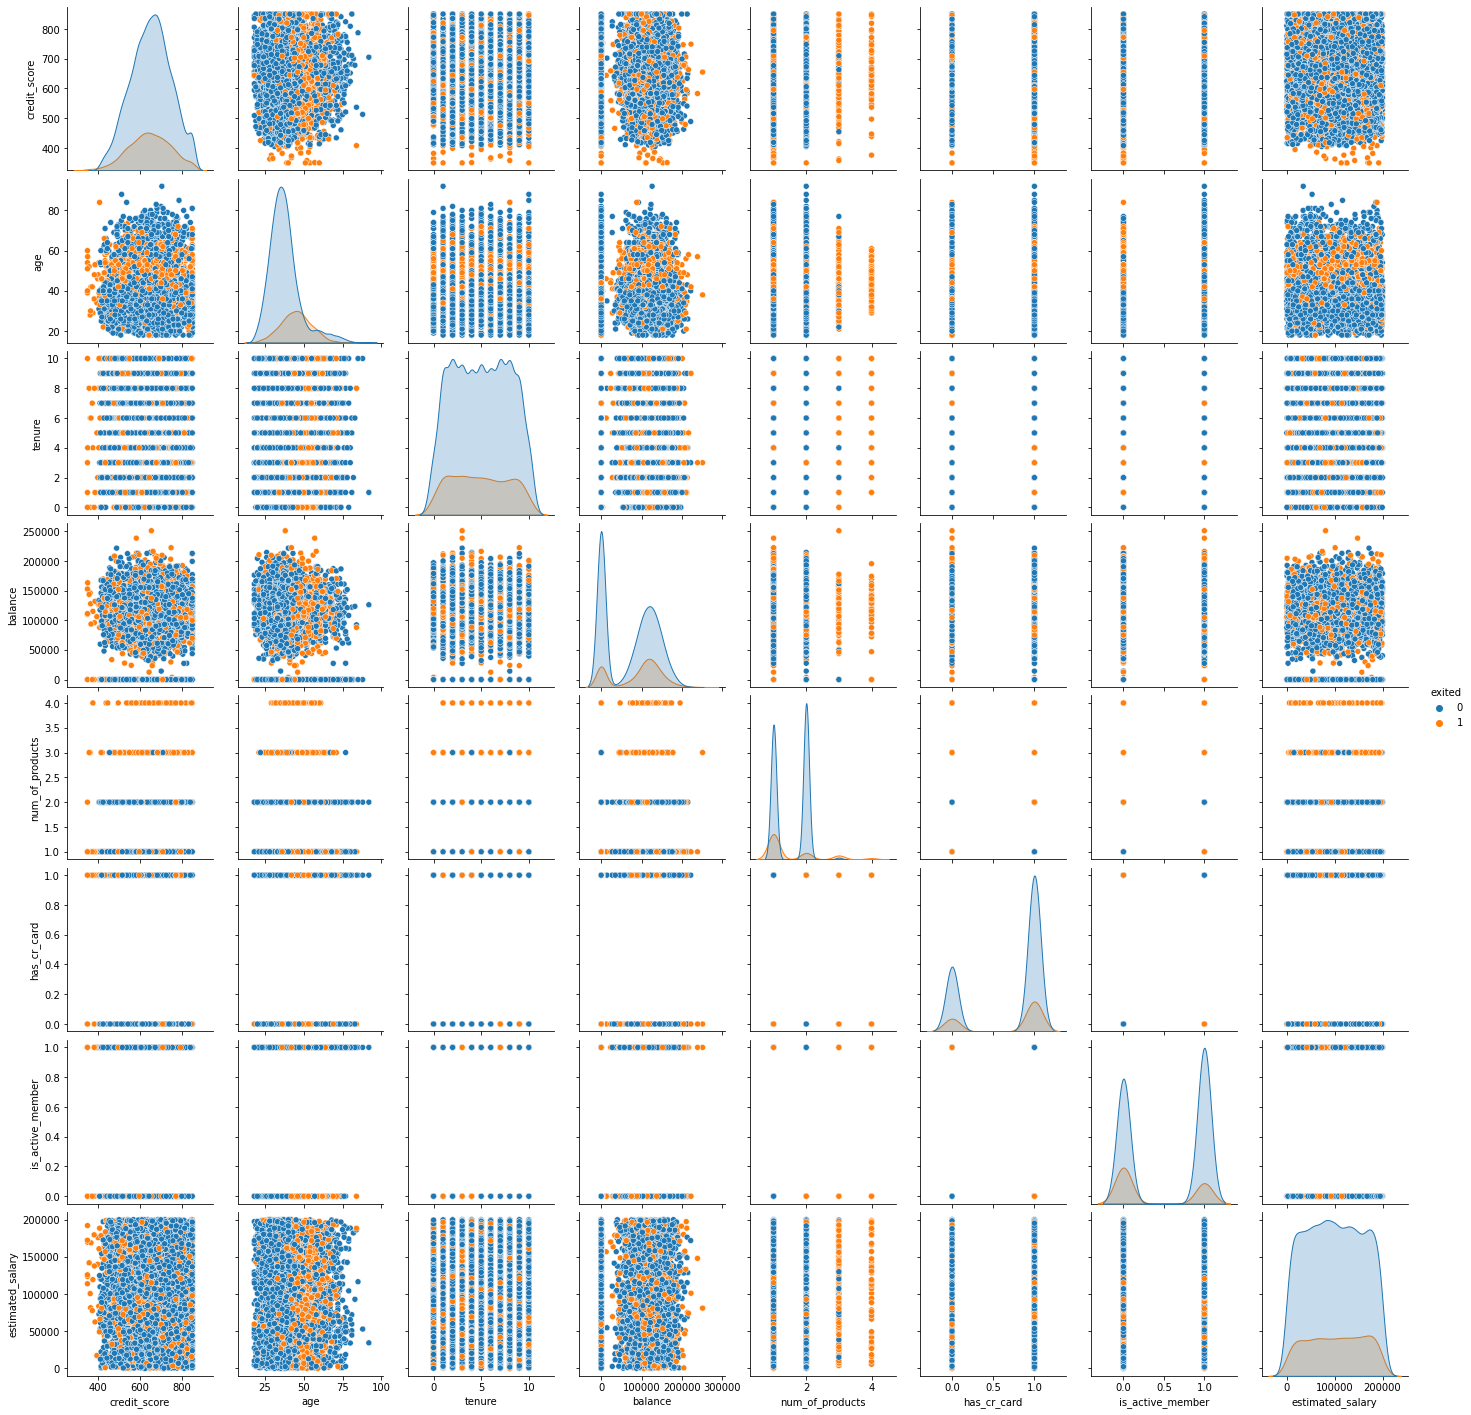

In [50]:
sb.pairplot(clients[clients.columns[2:13]], hue='exited');

Линейных корреляций нет вообще. Точки находятся в сложной нелинейной зависимости.

There are no linear correlations at all. The points are in a complex non-linear relationship.

## Подготовка данных / Datat preparation

Удалим лишние колонки из датасета (**customer_id**, **surname**).

Remove extra columns from dataset (**customer_id**, **surname**)

In [51]:
clients_clean = clients.drop(['customer_id', 'surname'], axis=1)
clients_clean.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Проведем кодирование категориальных переменных (**geography**, **gender**). В нашем случае подойдет прямое кодирование (one hot encoding). Такое кодирование подходит для большинства моделей. Порядковое кодирование не подойдет - у нас нет категориальных переменных, которые можно расставить в порядке приоритета (температуру можно: 1 - холодный, 2 - теплый, 3 - горячий).

-------

Categorical variables (**geography**, **gender**) encoding. In our case, direct encoding (one hot encoding) is suitable. This coding is suitable for most models. Ordinal coding will not work - we do not have categorical variables that can be arranged in order of priority (temperature can be: 1 - cold, 2 - warm, 3 - hot).

In [52]:
clients_clean = pd.get_dummies(data=clients_clean, columns=['geography', 'gender'], drop_first=True)
clients_clean.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Создадим переменные для целевого класса и фич.

Variables for features and target values.

In [53]:
features = clients_clean.drop('exited', axis=1)
features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [54]:
# стандартизируем признаки для логистической регрессии / features standardization for Logistic Regression
scaler = StandardScaler()
scaler.fit(features)
features_scaled = pd.DataFrame(scaler.transform(features), columns=features.columns)
features_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,-0.329200,0.289040,-1.035627,-1.227780,-0.912601,0.646896,0.96934,0.020264,-0.58078,-0.573159,-1.099164
1,-0.443301,0.194298,-1.381103,0.116887,-0.912601,-1.545844,0.96934,0.214527,-0.58078,1.744717,-1.099164
2,-1.542828,0.289040,1.037224,1.333920,2.529911,0.646896,-1.03163,0.238632,-0.58078,-0.573159,-1.099164
3,0.500631,0.004815,-1.381103,-1.227780,0.808655,-1.545844,-1.03163,-0.110281,-0.58078,-0.573159,-1.099164
4,2.066937,0.383782,-1.035627,0.785996,-0.912601,0.646896,0.96934,-0.366132,-0.58078,1.744717,-1.099164


In [55]:
target = clients_clean['exited']
target.head()

RowNumber
1    1
2    0
3    1
4    0
5    0
Name: exited, dtype: int64

Разделим данные на тренировочный, валидационный, и тестовый наборы. Сначала разделим весь датасет на тренировочный (70%) и оставшиеся наблюдения. Затем, разделим последний поровну на валидационный (15%) и тренировочный (15%).

-----

We divide the data into training, validation, and test sets. First, we divide the entire dataset into training (70%) and the remaining observations. Then, we divide the latter equally into validation (15%) and training (15%).

In [56]:
features_train, features_rem, target_train, target_rem = train_test_split(features, target, test_size=0.3, random_state=1)

print('Размерность тренировочных признаков:',features_train.shape)
print('Размерность тренировочного целевого признака:', target_train.shape)
print('Размерность оставшегося после разделения датасета:', features_rem.shape)
print('Размерность целевого признака после разделения:', target_rem.shape)

Размерность тренировочных признаков: (6363, 11)
Размерность тренировочного целевого признака: (6363,)
Размерность оставшегося после разделения датасета: (2728, 11)
Размерность целевого признака после разделения: (2728,)


In [57]:
features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, train_size=0.5,
random_state=1)

print('Размерность валидационных признаков:',features_valid.shape)
print('Размерность валидационного целевого признака:', target_valid.shape)
print('Размерность тестовых признаков:', features_test.shape)
print('Размерность тестового целевого признака:', target_test.shape)

Размерность валидационных признаков: (1364, 11)
Размерность валидационного целевого признака: (1364,)
Размерность тестовых признаков: (1364, 11)
Размерность тестового целевого признака: (1364,)


Данные готовы к построению моделей. Сначала мы изучим целевой класс и соотношения в нем, а затем построим модели без учета дисбаланса классов (если есть). Затем, посмотрим как исправление дисбоаланса влияет на точность классификации.

-----

The data is ready for building models. First, we will study the target class and the relationships in it, and then we will build models without taking into account class imbalance (if any). Next, let's see how the correction of imbalance affects the classification accuracy.

In [58]:
# разобьем на тренировочный, валидационный, и тестовый наборы СТАНДАРТИЗИРОВАННЫЕ данные для логистической 
# регрессии / split of STANDARDIZED data to train, test, and validation datasets for logistic regression
features_scaled_train, features_scaled_rem, target_train_lr, target_rem_lr = train_test_split(features_scaled, target, test_size=0.3, random_state=1)

print('Размерность тренировочных признаков:',features_scaled_train.shape)
print('Размерность тренировочного целевого признака:', target_train_lr.shape)
print('Размерность оставшегося после разделения датасета:', features_scaled_rem.shape)
print('Размерность целевого признака после разделения:', target_rem_lr.shape)

Размерность тренировочных признаков: (6363, 11)
Размерность тренировочного целевого признака: (6363,)
Размерность оставшегося после разделения датасета: (2728, 11)
Размерность целевого признака после разделения: (2728,)


In [59]:
features_scaled_valid, features_scaled_test, target_valid_lr, target_test_lr = train_test_split(features_scaled_rem, target_rem_lr, train_size=0.5,
random_state=1)

print('Размерность валидационных признаков:',features_scaled_valid.shape)
print('Размерность валидационного целевого признака:', target_valid_lr.shape)
print('Размерность тестовых признаков:', features_scaled_test.shape)
print('Размерность тестового целевого признака:', target_test_lr.shape)

Размерность валидационных признаков: (1364, 11)
Размерность валидационного целевого признака: (1364,)
Размерность тестовых признаков: (1364, 11)
Размерность тестового целевого признака: (1364,)


## Исследование задачи / Problem research

Проверим какое соотношение классов в целевом признаке.

Ratio of target classes.

In [60]:
clients['exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

### Проверка **БАЗОВЫХ** моделей без учета дисбаланса классов / Development of basic models without accounting for disbalance in target classes.

Соотношение положительных и отрицательных классов 1:4. Видим крупный дисбаланс классов. Взвешивание классов в таком случае не поможет, оно обычно применяется, когда разбежка в соотношении классов максимум в 2 раза. Можем применить **upsampling** и **downsampling** для исправления дисбаланса. Но сначала обучим модель на этих данных, чтобы получить метрики плохой модели и анализировать ее улучшение позже. Обучим логистическую регрессию (ЛР), дерево решений (ДР), и случайный лес (СЛ) без оптимизации гиперпараметров (БАЗОВЫЕ модели).

-----

The ratio of positive and negative classes is 1:4. We see a major class imbalance. Class weighting will not help in this case, it is usually used when the difference in the ratio of classes is a maximum of 2 times. We can use **upsampling** and **downsampling** to fix the imbalance. But first, we will train the model on this data in order to get the metrics of the bad model and analyze its improvement later. Train logistic regression (LR), decision tree (DT), and random forest (RF) without hyperparameter optimization (BASE models).

In [61]:

model_lr = LogisticRegression(random_state=1)
model_dt = DecisionTreeClassifier(random_state=1) # без оптимизации параметров
model_rf = RandomForestClassifier(random_state=1) # без оптимизации параметров

model_lr.fit(features_train, target_train)
model_dt.fit(features_train, target_train)
model_rf.fit(features_train, target_train)

lr_valid_predicted = model_lr.predict(features_valid) 
dt_valid_predicted = model_dt.predict(features_valid)
rf_valid_predicted = model_rf.predict(features_valid)

Построим матрицы ошибок для всех моделей.

Confusion matrix fro all models.

In [62]:
# lr
confusion_matrix(target_valid, lr_valid_predicted)

array([[1077,   27],
       [ 246,   14]])

In [63]:
# dt
confusion_matrix(target_valid, dt_valid_predicted)

array([[924, 180],
       [127, 133]])

In [64]:
# rf
confusion_matrix(target_valid, rf_valid_predicted)

array([[1055,   49],
       [ 139,  121]])

Результаты показывают, что модели хорошо предсказывает отрицательный класс (**TN**) и плохо положительный класс (**TP**). Из-за дисбаланса классов в сторону отрицательного, модели имеют много ложноотрицательных (**FN**) ответов. Ложноположительные (**FP**) ответы находятся на низком уровне у всех моделей, кроме **дерева решений** (их аж 180).

-----

The results show that the models predict well the negative class (**TN**) and poorly predict the positive class (**TP**). Due to the negative class imbalance, the models have many false negative (**FN**) responses. False positive (**FP**) responses are low in all models, except for the **decision tree** (there are already 180 of them).

Рассчитаем такие метрики, как полнота (recall) и точность (precision).

Calculate precision and recall.

In [65]:
recall_lr = recall_score(target_valid, lr_valid_predicted)
recall_dt = recall_score(target_valid, dt_valid_predicted)
recall_rf = recall_score(target_valid, rf_valid_predicted)

print('Recall для логистической регресии:', round(recall_lr, 2))
print('Recall для дерева решений:', round(recall_dt,2))
print('Recall для случайного леса:', round(recall_rf, 2))

Recall для логистической регресии: 0.05
Recall для дерева решений: 0.51
Recall для случайного леса: 0.47


**Recall** показывает как модель умеет находить положительные ответы. Эта метрика должна стремиться к 1. Логистическая регрессия плохо справляется с этой задачей (эффект дисбаланса классов). Дерево решений и случайный лес примерно одинаково справляются с поиском положительных классов (0.51 vs 0.47) - модели нашли примерно половину из всех положительных ответов. Можно сказать, что дисбаланс классов влияет в меньшей мере на ДР и СЛ, в сравнении с логистической регрессией.

----

**Recall** shows how the model is able to find positive responses. This metric should tend to 1. Logistic regression does a poor job of doing this (class imbalance effect). The decision tree and random forest are about the same in finding positive classes (0.51 vs 0.47) - the models found about half of all positive answers. It can be said that the class imbalance affects the DR and SL to a lesser extent, in comparison with the logistic regression.

In [66]:
precision_lr = precision_score(target_valid, lr_valid_predicted)
precision_dt = precision_score(target_valid, dt_valid_predicted)
precision_rf = precision_score(target_valid, rf_valid_predicted)

print('Precision для логистической регресии:', round(precision_lr, 2))
print('Precision для дерева решений:', round(precision_dt,2))
print('Precision для случайного леса:', round(precision_rf, 2))

Precision для логистической регресии: 0.34
Precision для дерева решений: 0.42
Precision для случайного леса: 0.71


Метрика **Precision** показывает какая часть наблюдений, помеченная моделью как "1", действительно таковой является. В меньшей степени дисбаланс классов повлиял на СЛ (71% правильно классифицированных положительных классов). На втором месте по этой метрике расположилось ДР - 42%. На последнем месте ЛР с 34%.

----

The **Precision** metric shows which part of the observations, marked as "1" by the model, is really such. To a lesser extent, class imbalance affected ST (71% of correctly classified positive classes). In second place according to this metric is the DR - 42%. Last place is LR with 34%.

Чтобы объединить метрики **Recall** и **Precision**, была создана метрика **F1**. Рассчитаем ее для всех моделей. Чем ближе эта мера к 1, тем лучше. Это означает, что модель умеет находить положительные классы и правильно их помечает.

----

To combine the **Recall** and **Precision** metrics, the **F1** metric was created. Let's calculate it for all models. The closer this measure is to 1, the better. This means that the model can find positive classes and label them correctly.

In [67]:
f1_lr = round(f1_score(target_valid, lr_valid_predicted),2)
f1_dt = round(f1_score(target_valid, dt_valid_predicted),2)
f1_rf = round(f1_score(target_valid, rf_valid_predicted),2)

print('F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии на дисбалансированных данных:', f1_lr)
print('F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений на дисбалансированных данных:', f1_dt)
print('F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса на дисбалансированных данных:', f1_rf)

F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии на дисбалансированных данных: 0.09
F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений на дисбалансированных данных: 0.46
F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса на дисбалансированных данных: 0.56


In [69]:
model_scaled_lr = LogisticRegression(random_state=1)

model_scaled_lr.fit(features_scaled_train, target_train_lr)

lr_valid_predicted_scaled = model_scaled_lr.predict(features_scaled_valid) 

f1_scaled_lr = round(f1_score(target_valid_lr, lr_valid_predicted_scaled),2)


print('F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии на СТАНДАРТИЗИРОВАННЫХ дисбалансированных данных:', f1_scaled_lr)

F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии на СТАНДАРТИЗИРОВАННЫХ дисбалансированных данных: 0.32


Посчитаем ROC-AUC для этих моделей.

Calculate ROC-AUC for these models.

In [70]:
predicted_proba_lr = model_lr.predict_proba(features_valid)
predicted_proba_dt = model_dt.predict_proba(features_valid)
predicted_proba_rf = model_rf.predict_proba(features_valid)

roc_auc_lr = round(roc_auc_score(target_valid, predicted_proba_lr[:,1]),2)
roc_auc_dt = round(roc_auc_score(target_valid, predicted_proba_dt[:,1]),2)
roc_auc_rf = round(roc_auc_score(target_valid, predicted_proba_rf[:,1]),2)

print('ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии на дисбалансированных данных:', roc_auc_lr)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений на дисбалансированных данных:', roc_auc_dt)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса на дисбалансированных данных:', roc_auc_rf)

ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии на дисбалансированных данных: 0.68
ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений на дисбалансированных данных: 0.67
ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса на дисбалансированных данных: 0.84


ЛР показала наихудшие результаты - F1-score = 0.09, а ROC-AUC = 0.68. Это значит ЛР работает немного лучше случайной модели (ROC-AUC = 0.5). Далее идет ДР со значением метрики F1 = 0.46, а ROC-AUC = 0.67. Работает лучше, чем ЛР, но такая точность нас не устраивает. Лучший результат показал СЛ - F1 = 0.56, ROC-AUC = 0.84. Учитывая все результаты, можно сказать, что дисбаланс классов очень повлиял на ЛР и в меньшей степени повлиял на ДР и СЛ. Но уже сейчас СЛ (без исправления дисбаланса классов и настройки гиперпараметров) показывает хорошие результаты. Далее мы настроим гиперапараметры моделей и посмотрим как они будут работать на **НЕСБАЛАНСИРОВАННЫХ** данных.

-----

LR showed the worst results - F1-score = 0.09, and ROC-AUC = 0.68. This means the LR performs slightly better than the random model (ROC-AUC = 0.5). Next comes the DT with the value of the metric F1 = 0.46, and ROC-AUC = 0.67. Works better than LR, but such accuracy does not suit us. The best result was shown by RF - F1 = 0.56, ROC-AUC = 0.84. Considering all the results, it can be said that the class imbalance greatly affected the LR and to a lesser extent affected the DR and RF. But already now, RF (without correcting the class imbalance and tweaking hyperparameters) is showing good results. Next, we'll tweak the hyperparameters of the models and see how they perform on **UNBALANCED** data.

### Проверка **ОТИМИЗИРОВАННЫХ** моделей без учета дисбаланса классов / Development of optimized models without accounting for target class disbalance.

Для начала настроим ЛР. У нее нет гиперпараметров для настройки, но есть порог (вероятность), выше которой модель будет учитывать класс как **положительный** (по умолчанию 0.5). Посмотрим как будут меняться полнота (Recall) и точность (Precision) при изменении порога.

-----

First, let's set up the LR. It has no hyperparameters to tune, but has a threshold (probability) above which the model will consider the class as **positive** (default 0.5). Let's see how the recall (Recall) and precision (Precision) will change when the threshold is changed.

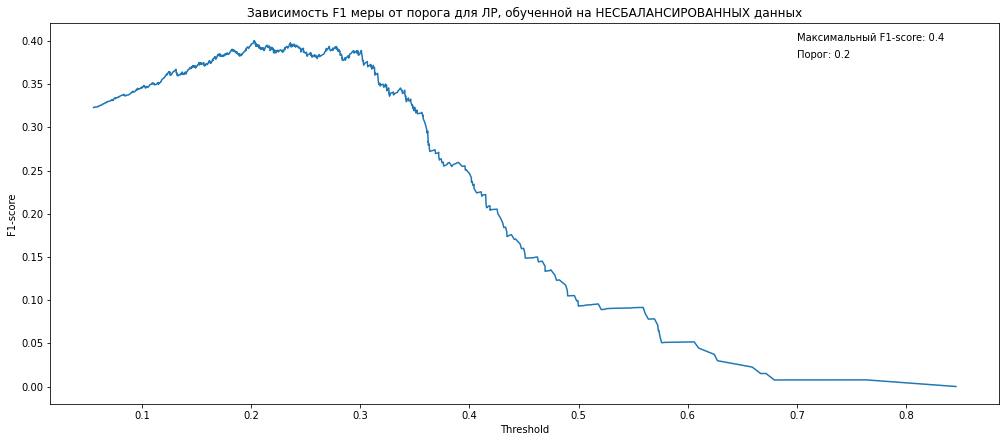

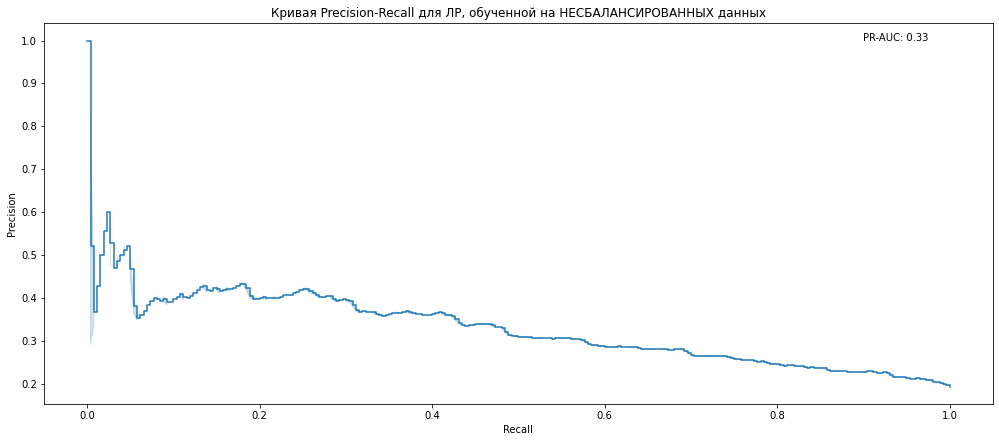

In [71]:
# используем вероятности для + класса, чтобы получить метрики
# precision и recall для различных порогов
precision, recall, thresholds = precision_recall_curve(target_valid, predicted_proba_lr[:, 1])
thresholds = list(thresholds)

#график зависимости F1-score от порогового значения
f = []
for thr in thresholds:
    predictions = predicted_proba_lr[:, 1] > thr
    f.append(f1_score(target_valid, predictions))

# получим максимальное значение F1-score и при каком пороге оно достигается
max_f = round(max(f), 2)
max_f_thresh_lr = round(thresholds[f.index(max(f))], 2)


plt.figure(figsize=(17,7))
sb.lineplot(x=thresholds, y=f)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Зависимость F1 меры от порога для ЛР, обученной на НЕСБАЛАНСИРОВАННЫХ данных')
plt.text(x=0.7, y=0.4, s='Максимальный F1-score: '+str(max_f))
plt.text(x=0.7, y=0.38, s='Порог: '+str(max_f_thresh_lr));

# построим PR-график
lr_pr_auc = round(auc(recall, precision),2) # найдем PR-AUC
plt.figure(figsize=(17,7))
sb.lineplot(x=recall, y=precision, drawstyle='steps-post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall для ЛР, обученной на НЕСБАЛАНСИРОВАННЫХ данных')
plt.text(x=0.9, y=1.0, s='PR-AUC: '+str(lr_pr_auc));


Для лучшего понимания ОПТИМИЗИРОВАННОЙ модели ЛР построим ROC-кривую и рассчитаем площадь под ней (AUC).

For a better understanding of the OPTIMIZED LR model, let's build an ROC curve and calculate the area under it (AUC).

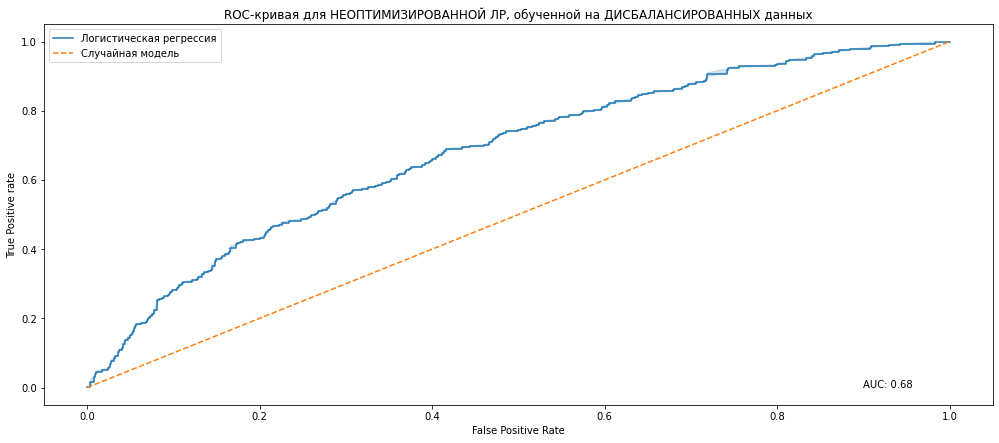

In [72]:
# рассчитаем true/false positive rate и пороговые значения
fpr, tpr, threshold = roc_curve(target_valid, predicted_proba_lr[:,1])

# сгенерируем случайную модель
ran_probs = [0 for _ in range(len(target_valid))] # вероятности + класса случайной модели
ran_fpr, ran_tpr, ran_threshold = roc_curve(target_valid, ran_probs)

lr_roc_auc = round(roc_auc_score(target_valid, predicted_proba_lr[:,1]),2)

# ROC-кривая
plt.figure(figsize=(17,7))
sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='Логистическая регрессия')
sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC-кривая для НЕОПТИМИЗИРОВАННОЙ ЛР, обученной на ДИСБАЛАНСИРОВАННЫХ данных')
plt.text(x=0.9, y=0.0, s='AUC: '+str(lr_roc_auc));

Как мы видим из PR-кривой, когда порог очень маленький, модель предсказывает одни положительные классы, поэтому, точность равна 1, а полнота - 0. С увеличением порога, модель предсказывает все меньше положительных классов, что приводит к росту полноты, но к падению точности. Модель не стремится к (1,1). Также, мы рассчитали площадь под PR-кривой - 0.33, что очень мало. У хорошей модели это значение должно быть ближе к 1. Мы не смогли выявить пороговое значение, при котором соблюдается баланс между полнотой и точностью.

ROC-кривая показывает, что модель ЛР работает немного лучше случайной модели: ROC-AUC случайной модели равна 0.5, ROC-AUC нашей логистической регрессии равна 0.68.

Позже проверим как исправление дисбаланса классов повлияет на модель и сможем ли мы подобрать пороговое значение.

-----

As we can see from the PR-curve, when the threshold is very small, the model predicts only positive classes, therefore, the accuracy is 1, and the recall is 0. As the threshold increases, the model predicts fewer and fewer positive classes, which leads to an increase in recall, but to a drop accuracy. The model does not tend to (1,1). Also, we calculated the area under the PR curve - 0.33, which is very small. A good model should have this value closer to 1. We have not been able to identify a threshold value that strikes a balance between recall and precision.

The ROC curve shows that the LR model performs slightly better than the random model: the ROC-AUC of the random model is 0.5, the ROC-AUC of our logistic regression is 0.68.

Later we will check how correcting the class imbalance will affect the model and whether we can pick up the threshold value.

Теперь настроим ДР. Самый главный гиперпараметр этой модели - **max_depth**.

Now let's build decision tree (DT). The most important hyperparameter of this model is **max_depth**.

Максимальное значение F1-score: 0.56


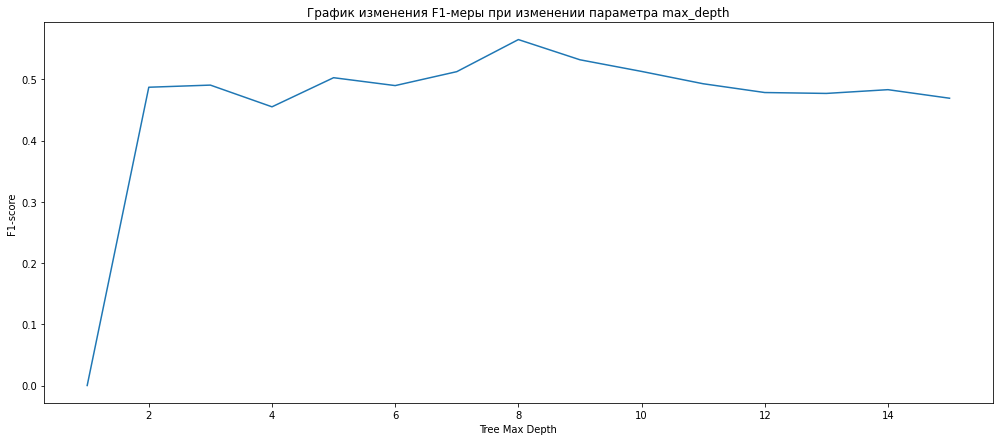

In [73]:
f_scores_opt_dt = []
depths_opt_dt = []
f_score = 0
opt_model_dt = None

# проверим max_depth от 1 до 15
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)

    # запишем лучший F-score и лучшую модель
    if f_score < f1_score(target_valid, predicted):
        f_score = f1_score(target_valid, predicted)
        opt_model_dt = model

    # добавим все F-score и глубины для графика
    f_scores_opt_dt.append(f1_score(target_valid, predicted))
    depths_opt_dt.append(depth)

plt.figure(figsize=(17,7))
sb.lineplot(x=depths_opt_dt, y=f_scores_opt_dt)
plt.xlabel('Tree Max Depth')
plt.ylabel('F1-score')
plt.title('График изменения F1-меры при изменении параметра max_depth');

print('Максимальное значение F1-score:', round(max(f_scores_opt_dt),2))

Из графика видно, что максимальное значение F1-меры достигается при глубине дерева **8**. Мы улучшили дерево решений и увеличили F1-score c 0.46 до 0.56. Построим ROC-кривую для моделей ДР с разной максимальной глубиной.

-----

It can be seen from the graph that the maximum value of the F1-measure is reached at a tree depth of **8**. We improved the decision tree and increased F1-score from 0.46 to 0.56. Let us construct an ROC curve for DR models with different maximum depths.

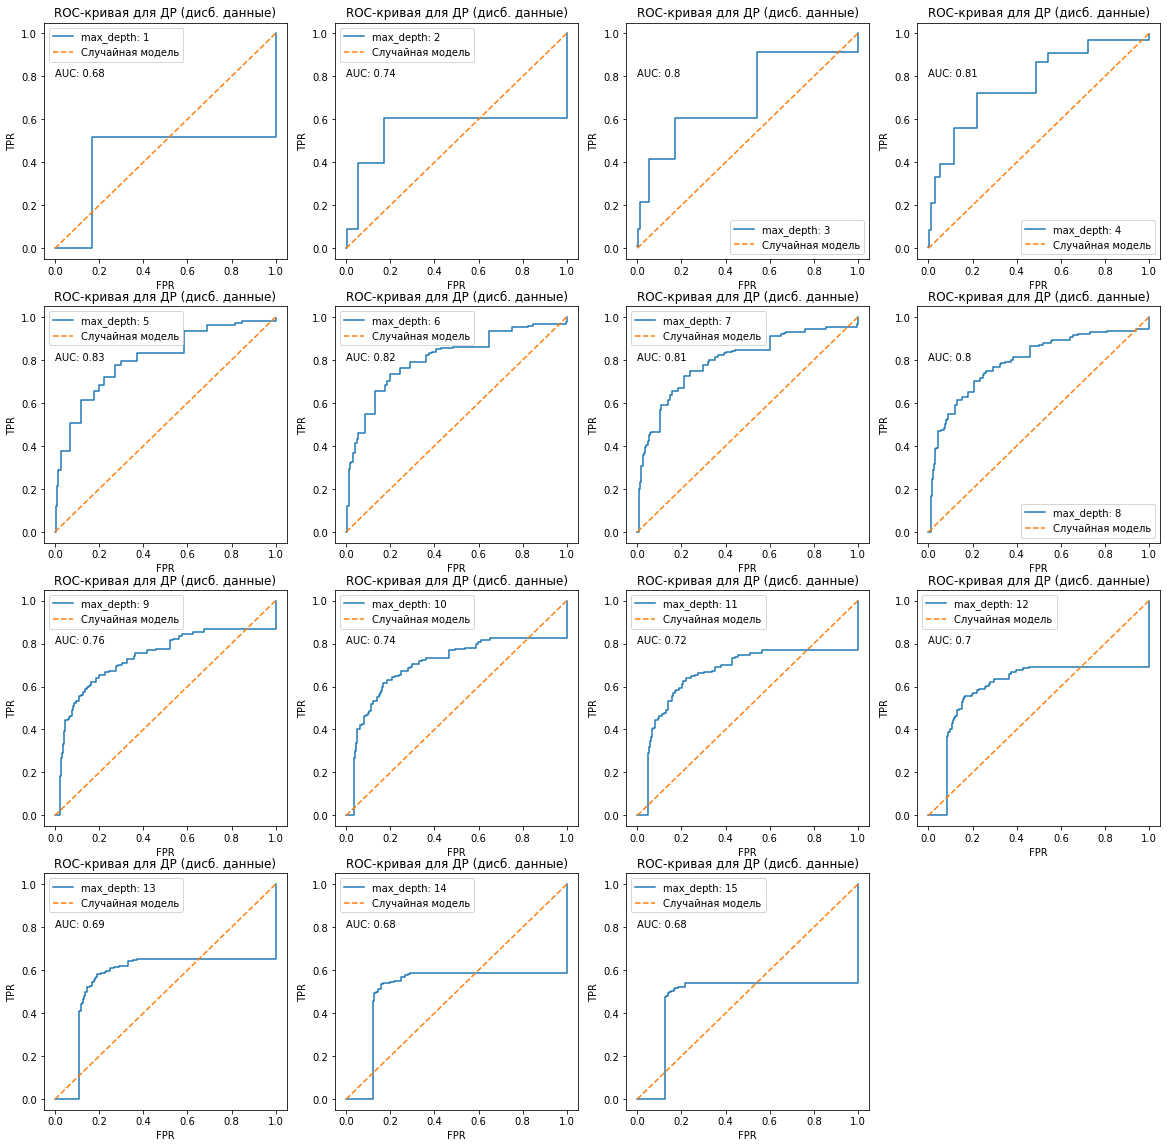

In [75]:
# настроим размер графика
fig = plt.figure(figsize=(20,20))

# проверим max_depth от 1 до 15 
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    predicted_proba = model.predict_proba(features_valid)

    # найдем TPR и FPR для модели с max_depth=depth
    fpr, tpr, t = roc_curve(target_valid, predicted_proba[:,1])

    # посчитаем площадь под ROC-кривой
    area_uc = round(roc_auc_score(target_valid, predicted_proba[:,1]), 2)

    # построим график
    axes = fig.add_subplot(4, 4, depth)
    sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='max_depth: '+str(depth))
    sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-кривая для ДР (дисб. данные)')
    plt.text(y=0.8, x=0.0, s='AUC: '+str(area_uc))

Согласно ROC-кривой, ДР с параметром **max_depth** от 5 до 8 работают отлично, чего не скажешь по F1-мере (от 5 до 7).

According to the ROC curve, DT with **max_depth** from 5 to 8 work fine, which can't be said for the F1 measure (from 5 to 7).

Осталось проверить как работает оптимизированная модель СЛ на НЕСБАЛАНСИРОВАННЫХ данных. Оптимизировать будет два параметра: **n_estimators** и **max_depth**.

-----

It remains to check how the optimized random forest (RF) model works on UNBALANCED data. There will be two parameters to optimize: **n_estimators** and **max_depth**.

Лучший показатель F-score: 0.59
Лучшая модель имеет max_depth=14 и n_estimators=70


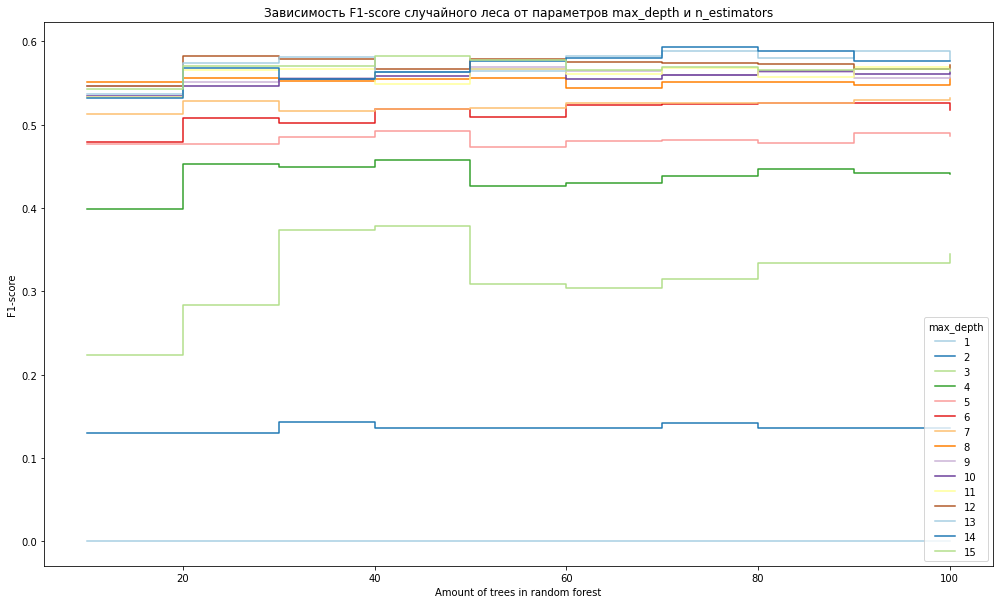

In [76]:
# -------- Случайный лес ----------------------

opt_model_rf = None # для сохранения лучшей модели
rf_opt_accuracy = 0 # для сохранения лучшей точности
rf_opt_n_est = 0 # для сохранения лучшего количества деревьев
rf_opt_depth = 0 # для сохранения лучшей глубины
rf_accuracies = {} # для всех значений точности (ключ - max_depth)
rf_depth = [depth for depth in range(1,16)] # для всех значений глубины
rf_n_est = [n for n in range(10,110,10)] # для всех значений количества деревьев

# проверим значения max_depth от 1 до 15
# проверим значения n_estimatirs от 10 до 100 с шагом 10
for depth in rf_depth:
    temp_accuracies = [] # сохраняем точности моделей с различным кол-вом деревьев
    for n in rf_n_est:
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=n)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = f1_score(target_valid, predictions)
        temp_accuracies.append(accuracy) # присоединим точность для модели с глубиной depth и кол-вом деревьев
        # от 10 до 100 с шагом 10
        if accuracy > rf_opt_accuracy:
            opt_model_rf = model
            rf_opt_accuracy = accuracy
            rf_opt_n_est = n
            rf_opt_depth = depth
    rf_accuracies[depth] = temp_accuracies # присоединим лист с точностями в словарь, где ключ - глубина depth

# создадим дадафрэйм с результатами и применим к нему функцию melt,
# чтобы построить график
rf_model_df = pd.DataFrame(rf_accuracies, index=rf_n_est).melt(value_vars=rf_depth, value_name='accuracy', var_name='max_depth')

# покажем как менется точность случайного леса
# в зависимости от количества деревьев в нем и их глубины
plt.figure(figsize=(17,10))
sb.lineplot(x=rf_n_est*15, y='accuracy', drawstyle='steps-post', data=rf_model_df, hue='max_depth', palette='Paired')
plt.title('Зависимость F1-score случайного леса от параметров max_depth и n_estimators')
plt.xlabel('Amount of trees in random forest')
plt.ylabel('F1-score');
plt.legend(title='max_depth', loc='lower right')

print('Лучший показатель F-score:', round(rf_opt_accuracy,2))
print(f'Лучшая модель имеет max_depth={opt_model_rf.max_depth} и n_estimators={opt_model_rf.n_estimators}')

График показывает, что максимальное значение F-меры, равное **0.59**, достигается при max_depth=14 и n_estimators=70. Построим ROC-кривую для лучшей модели СЛ.

-----

The plot shows that the maximum F-score of **0.59** is reached with max_depth=14 and n_estimators=70. Let us construct an ROC curve for the best RF model.

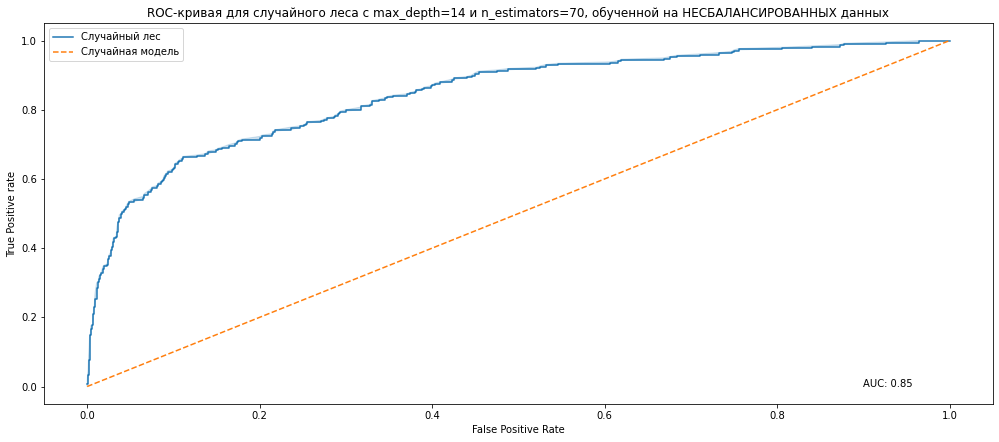

In [77]:
predicted_proba = opt_model_rf.predict_proba(features_valid)

# рассчитаем true/false positive rate и пороговые значения
fpr, tpr, threshold = roc_curve(target_valid, predicted_proba[:,1])

rf_roc_auc = round(roc_auc_score(target_valid, predicted_proba[:,1]),2)

# ROC-кривая
plt.figure(figsize=(17,7))
sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='Случайный лес')
sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC-кривая для случайного леса с max_depth=14 и n_estimators=70, обученной на НЕСБАЛАНСИРОВАННЫХ данных')
plt.text(x=0.9,y=0.0,s='AUC: '+str(rf_roc_auc));

Оптимизированная модель случайного леса имеет высокий показатель AUC-ROC: **0.85**. Такое значение указывает на модель, способную давать высокий TPR при низком FPR. Похоже, что дисбаланс меньше всего влияет на модель случайного леса. Далее мы решим проблему дисбаланса и обучим модели на новых данных.

---

The optimized random forest model has a high AUC-ROC: **0.85**. This value indicates a model capable of delivering high TPR at low FPR. The imbalance seems to have the least effect on the random forest model. Next, we will solve the imbalance problem and train the models on the new data.

#### Вывод / Conclusion

Ниже представлена таблица показателей трех моделей, обученных на НЕСБАЛАНСИРОВАННЫХ данных до оптимизации гиперапараметров и после.

----

Below is a table of performance of three models trained on UNBALANCED data before and after hyperparameter optimization.

In [78]:
disb_result = pd.DataFrame({
                            'Model':['LR', 'LR', 'DT', 'DT', 'RF', 'RF'],
                            'Before Opt': [f1_lr,roc_auc_lr,f1_dt,roc_auc_dt,f1_rf,roc_auc_rf],
                            'After Opt': [0.4,None,0.56,0.8,0.59,0.85]
                            }, index=['F-score', 'AUC-ROC']*3)

disb_result

,Model,Before Opt,After Opt
F-score,LR,0.09,0.40
AUC-ROC,LR,0.68,NaN
F-score,DT,0.46,0.56
AUC-ROC,DT,0.67,0.80
F-score,RF,0.56,0.59
AUC-ROC,RF,0.84,0.85


- Оптимизация порогового значения для ЛР увеличило F1-score с  0.09 до 0.4 - очень большое увеличение AUC-ROC.

- Для ДР F1-score увеличился с 0.46 до 0.56, а ROC-AUC с 0.67 до 0.80.

- Для СЛ F1-score увеличился с 0.56 до 0.59, а ROC-AUC с 0.84 до 0.85. Незначительные улучшения.

Пока из всех моделей только **ОПТИМИЗИРОВАННЫЙ СЛ** (max_depth=14, n_estimators=70) дошел на целевого значения F1-score на **НЕСБАЛАНСИРОВАННЫХ** данных, при этом ROC-AUC >> F1-score.

-----

- Threshold optimization for LR increased F1-score from 0.09 to 0.4 - a very large increase in AUC-ROC.

- For DT, F1-score increased from 0.46 to 0.56, and ROC-AUC from 0.67 to 0.80.

- For RF, F1-score increased from 0.56 to 0.59, and ROC-AUC from 0.84 to 0.85. Minor improvements.

So far, of all models, only **OPTIMIZED RF** (max_depth=14, n_estimators=70) reached the target F1-score on **UNBALANCED** data, while ROC-AUC >> F1-score.

## Борьба с дисбалансом / Removing unbalanced target classes

### Upsampling (БАЗОВЫЕ модели) / Upsampling (BASE models)

Мы выяснили, что соотношение классов 1:4. Это большой дисбаланс, его надо убрать. Применим технику **upsampling**.

We found out that the ratio of classes is 1:4. This is a big imbalance that needs to be removed. Let's use the **upsampling** technique.

In [79]:
# upsampling (увеличиваем позитивный класс)

# разделим обучающие данные на + и - классы
pos_class_features = features_train[target==1]
pos_class_target = target_train[target==1]
neg_class_features = features_train[target==0]
neg_class_target = target_train[target==0]

# увеличим количество позитивных классов
features_train_upsampled = pd.concat([neg_class_features] + [pos_class_features] * 4)
target_train_upsampled = pd.concat([neg_class_target] + [pos_class_target] * 4)

#перемешаем данные
features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=1);
target_train_upsampled.value_counts()

/tmp/ipykernel_36/2104223241.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_class_features = features_train[target==1]
/tmp/ipykernel_36/2104223241.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_class_features = features_train[target==0]


1    5220
0    5058
Name: exited, dtype: int64

В тренировочном наборе теперь поровну классов. Проведем тренировку наших БАЗОВЫХ моделей и рассчитаем основные метрики.

---

The training set now has an equal number of classes. Let's train our BASIC models and calculate the main metrics.

In [80]:
# обучение моделей
model_lr.fit(features_train_upsampled, target_train_upsampled)
model_dt.fit(features_train_upsampled, target_train_upsampled)
model_rf.fit(features_train_upsampled, target_train_upsampled)

# предсказания
lr_valid_predicted = model_lr.predict(features_valid)
dt_valid_predicted = model_dt.predict(features_valid)
rf_valid_predicted = model_rf.predict(features_valid)

# расчет F1-меры
f1_lr = round(f1_score(target_valid, lr_valid_predicted),2)
f1_dt = round(f1_score(target_valid, dt_valid_predicted),2)
f1_rf = round(f1_score(target_valid, rf_valid_predicted),2)

print('F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после UPSAMPLING:', f1_lr)
print('F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после UPSAMPLING:', f1_dt)
print('F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после UPSAMPLING:', f1_rf)

print('-----------------------------------------------------------------------------')

roc_auc_lr = round(roc_auc_score(target_valid, predicted_proba_lr[:,1]),2)
roc_auc_dt = round(roc_auc_score(target_valid, predicted_proba_dt[:,1]),2)
roc_auc_rf = round(roc_auc_score(target_valid, predicted_proba_rf[:,1]),2)

print('ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после UPSAMPLING:', roc_auc_lr)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после UPSAMPLING:', roc_auc_dt)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после UPSAMPLING:', roc_auc_rf)

pd.DataFrame({
                            'Model':['LR_unopt', 'LR_unopt', 'DT_unopt', 'DT_unopt', 'RF_unopt', 'RF_unopt'],
                            'Before Upsampling': [0.09, 0.68, 0.46, 0.67, 0.56, 0.84],
                            'After Upsampling': [f1_lr,roc_auc_lr,f1_dt,roc_auc_dt,f1_rf,roc_auc_rf]
                            }, index=['F-score', 'AUC-ROC']*3)

F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после UPSAMPLING: 0.42
F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после UPSAMPLING: 0.47
F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после UPSAMPLING: 0.6
-----------------------------------------------------------------------------
ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после UPSAMPLING: 0.68
ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после UPSAMPLING: 0.67
ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после UPSAMPLING: 0.84


,Model,Before Upsampling,After Upsampling
F-score,LR_unopt,0.09,0.42
AUC-ROC,LR_unopt,0.68,0.68
F-score,DT_unopt,0.46,0.47
AUC-ROC,DT_unopt,0.67,0.67
F-score,RF_unopt,0.56,0.60
AUC-ROC,RF_unopt,0.84,0.84


Техника **upsampling** помогла улучшить метрики **БАЗОВЫХ** моделей: 

- Для ЛР улучшения значительные, а для ДР и СЛ - нет. 

- Видно, что **НЕОПТИМИЗИРОВАННАЯ** модель **СЛ** достигает целевого значения F1-меры после балансировки данных методом **upsampling**.

----

The **upsampling** technique helped improve the metrics of **BASE** models:

- Significant improvement for LR, but not for DT and RF.

- It can be seen that the **UNOPTIMIZED** **RF** model reaches the target value of the F1-score after balancing the data with the **upsampling** method.

### Downsampling (БАЗОВЫЕ модели) / Downsampling (BASE models)

In [81]:
# downsampling (уменьшаем - класс)

# разделим обучающие данные на + и - классы
pos_class_features = features_train[target==1]
pos_class_target = target_train[target==1]
neg_class_features = features_train[target==0]
neg_class_target = target_train[target==0]

# уменьшаем количество отрицательных классов
features_train_downsampled = pd.concat([neg_class_features.sample(frac=0.2, random_state=1)] + [pos_class_features])
target_train_downsampled = pd.concat([neg_class_target.sample(frac=0.2, random_state=1)] + [pos_class_target])

#перемешаем данные
features_train_downsampled, target_train_downsampled = shuffle(features_train_downsampled, target_train_downsampled, random_state=1);
target_train_downsampled.value_counts()

/tmp/ipykernel_36/4078234376.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_class_features = features_train[target==1]
/tmp/ipykernel_36/4078234376.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_class_features = features_train[target==0]


1    1305
0    1012
Name: exited, dtype: int64

Уменьшили отрицательный класс и теперь их соотношение 1:1. Проведем обучение НЕОПТИМИЗИРОВАННЫХ моделей на данных после **DOWNSAMPLING**.

----

Reduced the negative class and now their ratio is 1:1. Let's train UNOPTIMIZED models on data after **DOWNSAMPLING**.

In [82]:
# обучение моделей
model_lr.fit(features_train_downsampled, target_train_downsampled)
model_dt.fit(features_train_downsampled, target_train_downsampled)
model_rf.fit(features_train_downsampled, target_train_downsampled)

# предсказания
lr_valid_predicted = model_lr.predict(features_valid)
dt_valid_predicted = model_dt.predict(features_valid)
rf_valid_predicted = model_rf.predict(features_valid)

# расчет F1-меры
f1_lr = round(f1_score(target_valid, lr_valid_predicted),2)
f1_dt = round(f1_score(target_valid, dt_valid_predicted),2)
f1_rf = round(f1_score(target_valid, rf_valid_predicted),2)

print('F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после DOWNSAMPLING:', f1_lr)
print('F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после DOWNSAMPLING:', f1_dt)
print('F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после DOWNSAMPLING:', f1_rf)

print('-----------------------------------------------------------------------------')

roc_auc_lr = round(roc_auc_score(target_valid, predicted_proba_lr[:,1]),2)
roc_auc_dt = round(roc_auc_score(target_valid, predicted_proba_dt[:,1]),2)
roc_auc_rf = round(roc_auc_score(target_valid, predicted_proba_rf[:,1]),2)

print('ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после DOWNSAMPLING:', roc_auc_lr)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после DOWNSAMPLING:', roc_auc_dt)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после DOWNSAMPLING:', roc_auc_rf)

pd.DataFrame({
                            'Model':['LR_unopt', 'LR_unopt', 'DT_unopt', 'DT_unopt', 'RF_unopt', 'RF_unopt'],
                            'Before Downsampling': [0.09, 0.68, 0.46, 0.67, 0.56, 0.84],
                            'After Downsampling': [f1_lr,roc_auc_lr,f1_dt,roc_auc_dt,f1_rf,roc_auc_rf]
                            }, index=['F-score', 'AUC-ROC']*3)

F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после DOWNSAMPLING: 0.4
F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после DOWNSAMPLING: 0.44
F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после DOWNSAMPLING: 0.52
-----------------------------------------------------------------------------
ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после DOWNSAMPLING: 0.68
ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после DOWNSAMPLING: 0.67
ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после DOWNSAMPLING: 0.84


,Model,Before Downsampling,After Downsampling
F-score,LR_unopt,0.09,0.40
AUC-ROC,LR_unopt,0.68,0.68
F-score,DT_unopt,0.46,0.44
AUC-ROC,DT_unopt,0.67,0.67
F-score,RF_unopt,0.56,0.52
AUC-ROC,RF_unopt,0.84,0.84


Ни одна из моделей после **DOWNSAPLING** не достигла целевого значения F1-меры.
- Из сводной таблицы видно, что **DOWNSAMPLING** помог значительно улучшить F1-score у ЛР, но ROC-AUC снизилось. 

- Ухудшились оба показателя у ДР. 

- F1-score у СЛ снизился, а ROC-AUC незначительно увеличился.

---

None of the models after **DOWNSAPLING** reached the target value of the F1-score.
- From the summary table it can be seen that **DOWNSAMPLING** helped to significantly improve the F1-score in the LR, but the ROC-AUC decreased.

- Both indicators have deteriorated in DR.

- F1-score in RF decreased, and ROC-AUC slightly increased.

### Взвешивание классов (БАЗОВЫЕ модели) / Weighted BASE models

In [83]:
model_lr = LogisticRegression(random_state=1, class_weight='balanced')
model_dt = DecisionTreeClassifier(random_state=1, class_weight='balanced')
model_rf = RandomForestClassifier(random_state=1, class_weight='balanced')

# обучение моделей
model_lr.fit(features_train, target_train)
model_dt.fit(features_train, target_train)
model_rf.fit(features_train, target_train)

# предсказания
lr_valid_predicted = model_lr.predict(features_valid)
dt_valid_predicted = model_dt.predict(features_valid)
rf_valid_predicted = model_rf.predict(features_valid)

# расчет F1-меры
f1_lr = round(f1_score(target_valid, lr_valid_predicted),2)
f1_dt = round(f1_score(target_valid, dt_valid_predicted),2)
f1_rf = round(f1_score(target_valid, rf_valid_predicted),2)

print('F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после взвешивания классов:', f1_lr)
print('F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после взвешивания классов:', f1_dt)
print('F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после взвешивания классов:', f1_rf)

print('-----------------------------------------------------------------------------')

predicted_proba_lr = model_lr.predict_proba(features_valid)
predicted_proba_dt = model_dt.predict_proba(features_valid)
predicted_proba_rf = model_rf.predict_proba(features_valid)

roc_auc_lr = round(roc_auc_score(target_valid, predicted_proba_lr[:,1]),2)
roc_auc_dt = round(roc_auc_score(target_valid, predicted_proba_dt[:,1]),2)
roc_auc_rf = round(roc_auc_score(target_valid, predicted_proba_rf[:,1]),2)

print('ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после взвешивания классов:', roc_auc_lr)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после взвешивания классов:', roc_auc_dt)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после взвешивания классов:', roc_auc_rf)

pd.DataFrame({
                            'Model':['LR_unopt', 'LR_unopt', 'DT_unopt', 'DT_unopt', 'RF_unopt', 'RF_unopt'],
                            'Before Weighing': [0.09, 0.68, 0.46, 0.67, 0.56, 0.84],
                            'After Weighing': [f1_lr,roc_auc_lr,f1_dt,roc_auc_dt,f1_rf,roc_auc_rf]
                            }, index=['F-score', 'AUC-ROC']*3)

F1-score для НЕОПТИМИЗИРОВАННОЙ логистической регресии после взвешивания классов: 0.37
F1-score для НЕОПТИМИЗИРОВАННОГО дерева решений после взвешивания классов: 0.47
F1-score для НЕОПТИМИЗИРОВАННОГО случайного леса после взвешивания классов: 0.55
-----------------------------------------------------------------------------
ROC-AUC для НЕОПТИМИЗИРОВАННОЙ логистической регресии после взвешивания классов: 0.61
ROC-AUC для НЕОПТИМИЗИРОВАННОГО дерева решений после взвешивания классов: 0.68
ROC-AUC для НЕОПТИМИЗИРОВАННОГО случайного леса после взвешивания классов: 0.85


,Model,Before Weighing,After Weighing
F-score,LR_unopt,0.09,0.37
AUC-ROC,LR_unopt,0.68,0.61
F-score,DT_unopt,0.46,0.47
AUC-ROC,DT_unopt,0.67,0.68
F-score,RF_unopt,0.56,0.55
AUC-ROC,RF_unopt,0.84,0.85


**Взвешивание классов** не помогло достичь пороговой F1-меры.

- У ЛР значительно улучшилась F1-мера, но ухудшился показатель ROC-AUC.

- У ДР незначительно ухудшился F1-score, а ROC-AUC остался неизменным.

- Показатель F1 у СЛ остался неизменным, а ROC-AUC незначительно увеличился.

----

**Class weighting** failed to reach the threshold F1-score.

- The F1-score significantly improved in LR, but the ROC-AUC indicator worsened.

- DT's F1-score slightly deteriorated, while ROC-AUC remained unchanged.

- RF's F1 remained unchanged, while ROC-AUC slightly increased.

### Upsampling (ОПТИМИЗИРОВАННЫЕ модели) / Upsampling (OPTIMISED models)

Проведем оптимизацию порогового значения у ЛР, обученной на данных после **UPSAMPLING**, и проверим как меняются основные метрики.

---

Let's optimize the threshold value of the LR trained on the data after **UPSAMPLING** and check how the main metrics change.

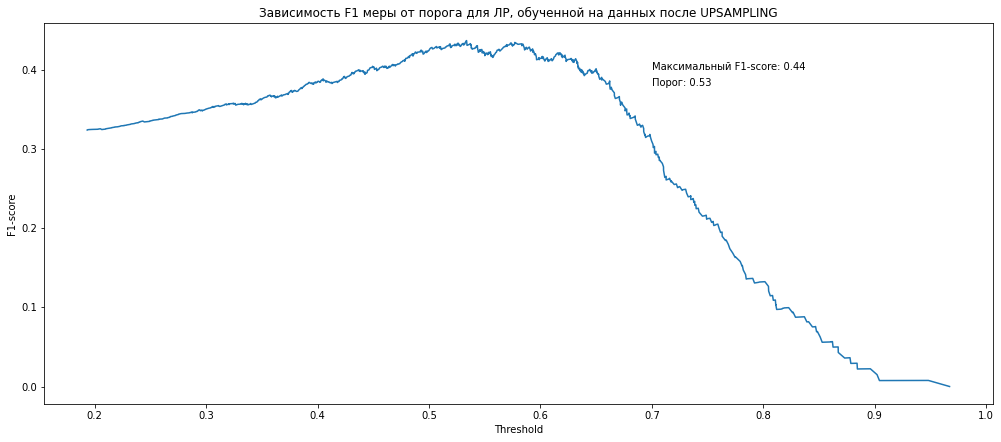

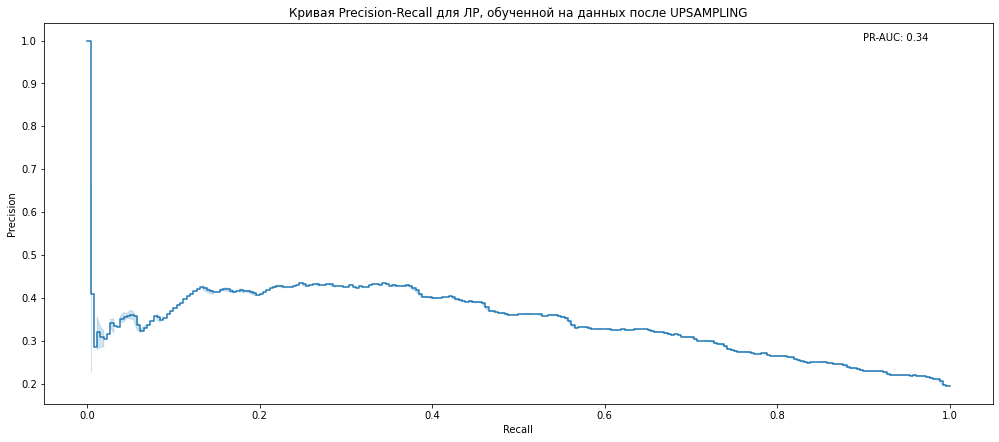

In [84]:
# обучим модель и найдем вероятности классов
model_lr = LogisticRegression(random_state=1)
model_lr.fit(features_train_upsampled, target_train_upsampled)
predicted_proba_lr_upsamp = model_lr.predict_proba(features_valid)

# используем вероятности для + класса, чтобы получить метрики
# precision и recall для различных порогов
precision, recall, thresholds = precision_recall_curve(target_valid, predicted_proba_lr_upsamp[:, 1])
thresholds = list(thresholds)

#график зависимости F1-score от порогового значения
f = []
for thr in thresholds:
    predictions = predicted_proba_lr_upsamp[:, 1] > thr
    f.append(f1_score(target_valid, predictions))

# получим максимальное значение F1-score и при каком пороге оно достигается
max_f = round(max(f), 2)
max_f_thresh_lr = round(thresholds[f.index(max(f))], 2)

plt.figure(figsize=(17,7))
sb.lineplot(x=thresholds, y=f)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Зависимость F1 меры от порога для ЛР, обученной на данных после UPSAMPLING')
plt.text(x=0.7, y=0.4, s='Максимальный F1-score: '+str(max_f))
plt.text(x=0.7, y=0.38, s='Порог: '+str(max_f_thresh_lr));

# построим PR-график
lr_pr_auc = round(auc(recall, precision),2) # найдем PR-AUC
plt.figure(figsize=(17,7))
sb.lineplot(x=recall, y=precision, drawstyle='steps-post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall для ЛР, обученной на данных после UPSAMPLING')
plt.text(x=0.9, y=1.0, s='PR-AUC: '+str(lr_pr_auc));

Оптимизация порогового значения ЛР помогла достигнуть F1-меры, равной 0.44, что не дотягивает до целевого значения.

----

Optimization of the LR threshold helped to achieve an F1 score of 0.44, which falls short of the target value.

Найдем оптимальное значение **max_depth** для ДР.

Find optimal **max_depth** for DT.

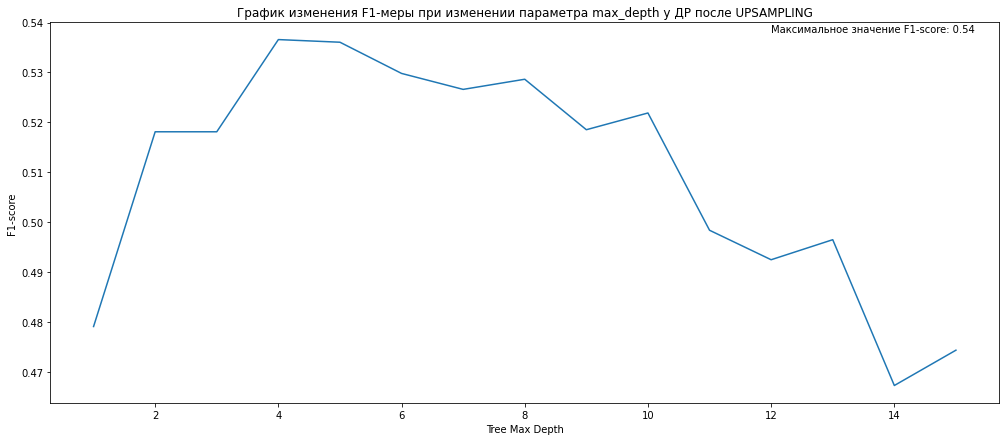

In [85]:
f_scores_opt_dt = []
depths_opt_dt = []
f_score = 0
opt_model_dt = None

# проверим max_depth от 1 до 15
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted = model.predict(features_valid)

    # запишем лучший F-score и лучшую модель
    if f_score < f1_score(target_valid, predicted):
        f_score = f1_score(target_valid, predicted)
        opt_model_dt = model

    # добавим все F-score и глубины для графика
    f_scores_opt_dt.append(f1_score(target_valid, predicted))
    depths_opt_dt.append(depth)

plt.figure(figsize=(17,7))
sb.lineplot(x=depths_opt_dt, y=f_scores_opt_dt)
plt.xlabel('Tree Max Depth')
plt.ylabel('F1-score')
plt.title('График изменения F1-меры при изменении параметра max_depth у ДР после UPSAMPLING')
plt.text(x=12, y=0.538, s='Максимальное значение F1-score: '+str(round(max(f_scores_opt_dt),2)));

Модель ДР выдает максимальное значение F1-меры при параметре **max_depth=4**. Оптимизация ДР увеличивает F1-score с **0.46** до **0.54**, однако, целевое значение не достигается.

Построим ROC-кривые для разных значений **max_depth**.

-----

The DT model outputs the maximum value of the F1-score with the parameter **max_depth=4**. DT optimization increases F1-score from **0.46** to **0.54**, however, the target value is not reached.

Let's build ROC curves for different values of **max_depth**.

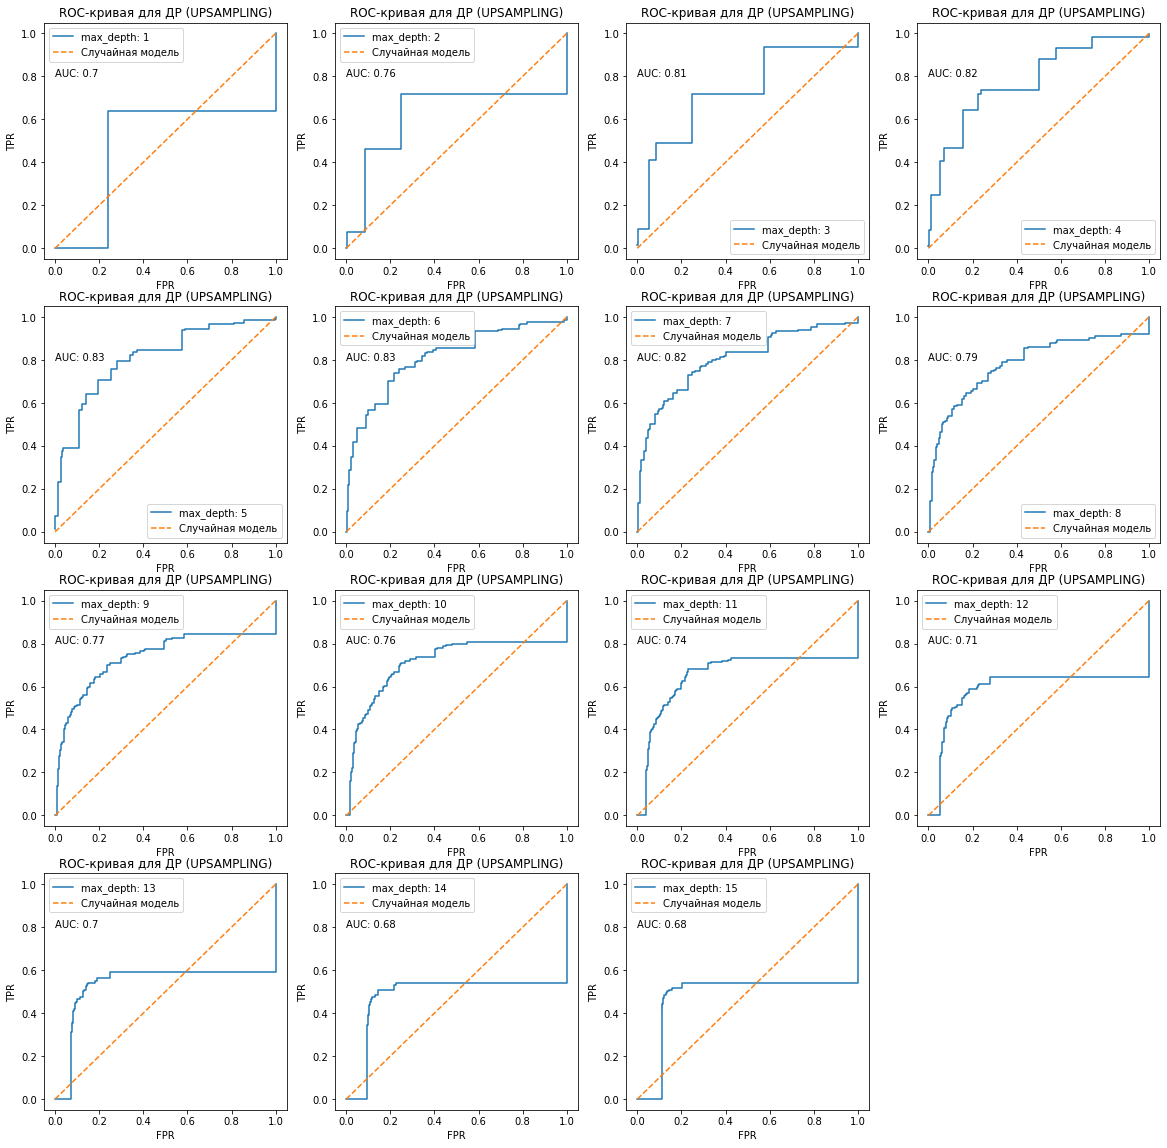

In [86]:
# настроим размер графика
fig = plt.figure(figsize=(20,20))

# проверим max_depth от 1 до 15 
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted = model.predict(features_valid)
    predicted_proba = model.predict_proba(features_valid)

    # найдем TPR и FPR для модели с max_depth=depth
    fpr, tpr, t = roc_curve(target_valid, predicted_proba[:,1])

    # посчитаем площадь под ROC-кривой
    area_uc = round(roc_auc_score(target_valid, predicted_proba[:,1]), 2)

    # построим график
    axes = fig.add_subplot(4, 4, depth)
    sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='max_depth: '+str(depth))
    sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-кривая для ДР (UPSAMPLING)')
    plt.text(y=0.8, x=0.0, s='AUC: '+str(area_uc))

При max_depth=4 ROC-AUC для ДР увеличивается с **0.67** до **0.82**.

With max_depth=4, ROC-AUC for DT increases from **0.67** to **0.82**.

Оптимизируем параметры **max_depth** и **n_estimators** у СЛ.

Optimize the **max_depth** and **n_estimators** parameters for the RF.

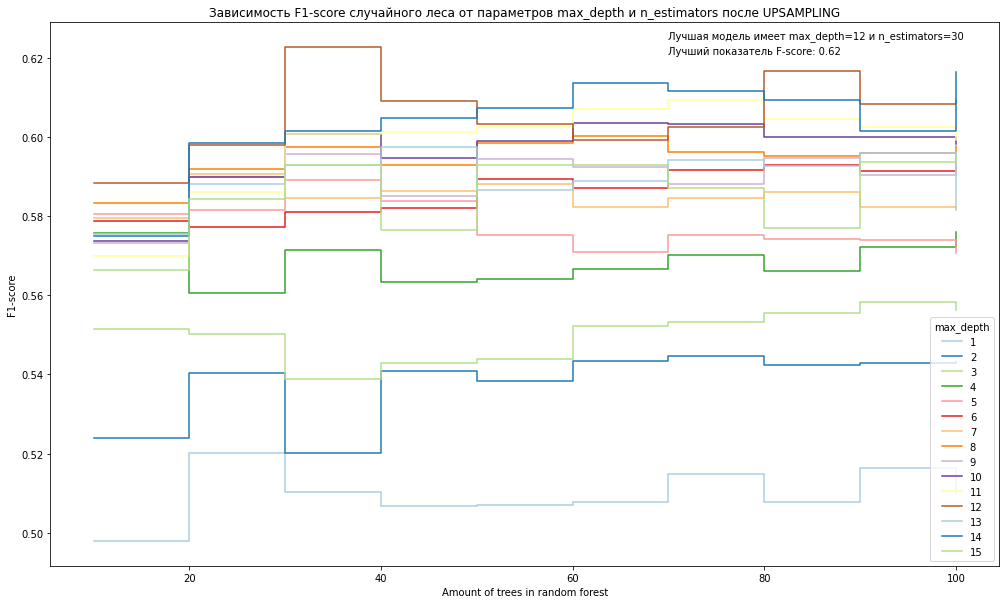

In [87]:
# -------- Случайный лес ----------------------

opt_model_rf = None # для сохранения лучшей модели
rf_opt_accuracy = 0 # для сохранения лучшей точности
rf_opt_n_est = 0 # для сохранения лучшего количества деревьев
rf_opt_depth = 0 # для сохранения лучшей глубины
rf_accuracies = {} # для всех значений точности (ключ - max_depth)
rf_depth = [depth for depth in range(1,16)] # для всех значений глубины
rf_n_est = [n for n in range(10,110,10)] # для всех значений количества деревьев

# проверим значения max_depth от 1 до 15
# проверим значения n_estimatirs от 10 до 100 с шагом 10
for depth in rf_depth:
    temp_accuracies = [] # сохраняем точности моделей с различным кол-вом деревьев
    for n in rf_n_est:
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=n)
        model.fit(features_train_upsampled, target_train_upsampled)
        predictions = model.predict(features_valid)
        accuracy = f1_score(target_valid, predictions)
        temp_accuracies.append(accuracy) # присоединим точность для модели с глубиной depth и кол-вом деревьев
        # от 10 до 100 с шагом 10
        if accuracy > rf_opt_accuracy:
            opt_model_rf = model
            rf_opt_accuracy = accuracy
            rf_opt_n_est = n
            rf_opt_depth = depth
    rf_accuracies[depth] = temp_accuracies # присоединим лист с точностями в словарь, где ключ - глубина depth

# создадим дадафрэйм с результатами и применим к нему функцию melt,
# чтобы построить график
rf_model_df = pd.DataFrame(rf_accuracies, index=rf_n_est).melt(value_vars=rf_depth, value_name='accuracy', var_name='max_depth')

# покажем как менется точность случайного леса
# в зависимости от количества деревьев в нем и их глубины
plt.figure(figsize=(17,10))
sb.lineplot(x=rf_n_est*15, y='accuracy', drawstyle='steps-post', data=rf_model_df, hue='max_depth', palette='Paired')
plt.title('Зависимость F1-score случайного леса от параметров max_depth и n_estimators после UPSAMPLING')
plt.xlabel('Amount of trees in random forest')
plt.ylabel('F1-score');
plt.legend(title='max_depth', loc='lower right')
plt.text(x=70, y=0.625, s=f'Лучшая модель имеет max_depth={opt_model_rf.max_depth} и n_estimators={opt_model_rf.n_estimators}')
plt.text(x=70, y=0.621, s='Лучший показатель F-score: '+str(round(rf_opt_accuracy,2)));

На данный момент модель СЛ с max_depth=12 и n_estimators=30 показывает наилучший результат - значение F1-score **0.62**, что превышает пороговое значение.

-----

At the moment, the RF model with max_depth=12 and n_estimators=30 shows the best result - F1-score **0.62**, which exceeds the threshold value.

Построим ROC-кривую для наилучшей модели СЛ.

Plot ROC-AUC curve for the best RF model.

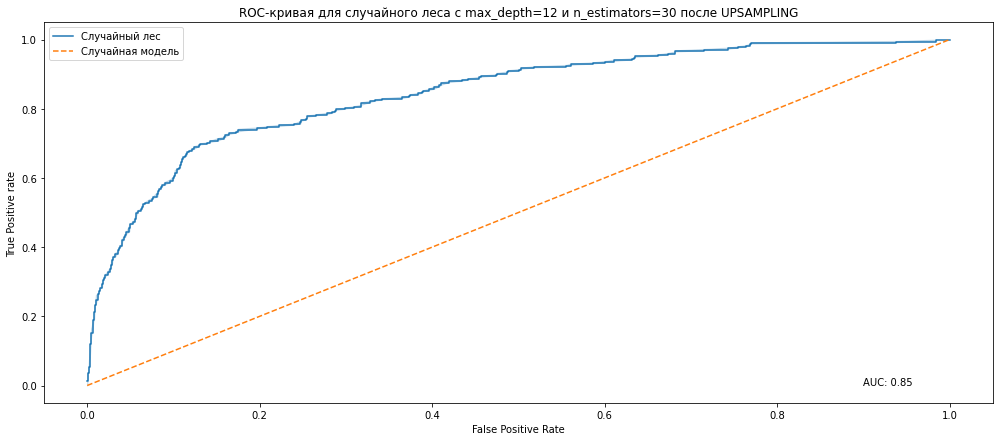

In [88]:
opt_model_rf = RandomForestClassifier(random_state=1, max_depth=12, n_estimators=30)
opt_model_rf.fit(features_train_upsampled, target_train_upsampled)
predicted_proba = opt_model_rf.predict_proba(features_valid)

# рассчитаем true/false positive rate и пороговые значения
fpr, tpr, threshold = roc_curve(target_valid, predicted_proba[:,1])

rf_roc_auc = round(roc_auc_score(target_valid, predicted_proba[:,1]),2)

# ROC-кривая
plt.figure(figsize=(17,7))
sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='Случайный лес')
sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC-кривая для случайного леса с max_depth=12 и n_estimators=30 после UPSAMPLING')
plt.text(x=0.9,y=0.0,s='AUC: '+str(rf_roc_auc));

Улучшенная модель СЛ, обученная на СБАЛАНСИРОВАННЫХ данных (**UPSAMPLING**) на данный момент показывает наилучшие результаты:

- **F1-score**: 0.62

- **ROC-AUC**: 0.85

----

The improved RF model trained on BALANCED data (**UPSAMPLING**) shows the best results so far:

- **F1-score**: 0.62

- **ROC-AUC**: 0.85

Теперь проверим как техника балансировки классов **DOWNSAMPLING** повлияет на точность улучшенных моделей.

Now let's check how the **DOWNSAMPLING** class balancing technique will affect the accuracy of the improved models.

### Downsampling (ОПТИМИЗИРОВАННЫЕ модели) / Downsampling (OPTIMISED models)

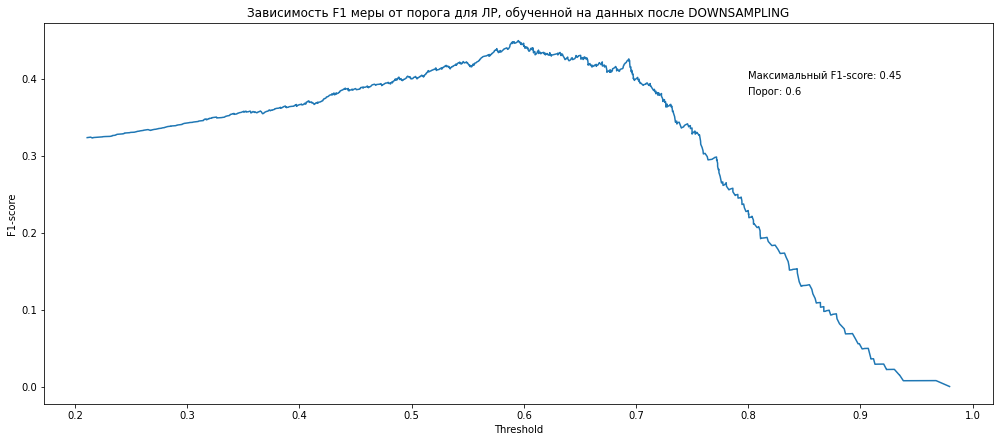

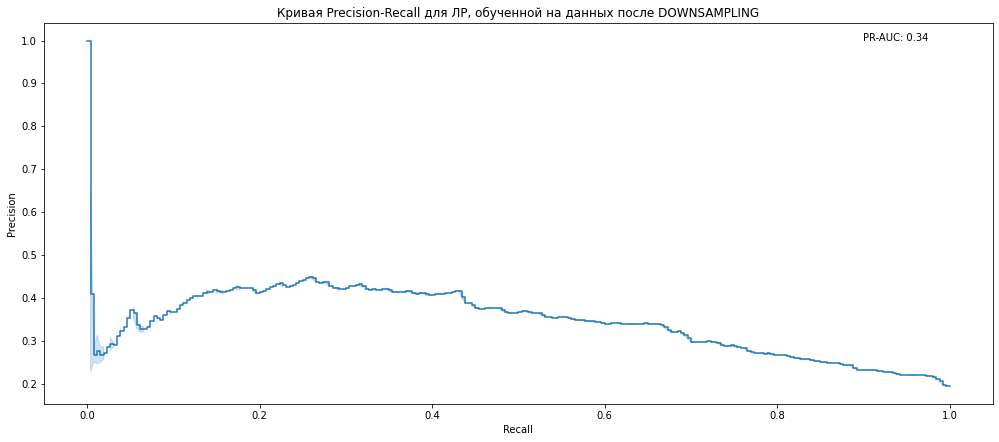

In [89]:
# -------- Логистическая регрессия ----------------------

# обучим модель и найдем вероятности классов
model_lr = LogisticRegression(random_state=1)
model_lr.fit(features_train_downsampled, target_train_downsampled)
predicted_proba_lr_upsamp = model_lr.predict_proba(features_valid)

# используем вероятности для + класса, чтобы получить метрики
# precision и recall для различных порогов
precision, recall, thresholds = precision_recall_curve(target_valid, predicted_proba_lr_upsamp[:, 1])
thresholds = list(thresholds)

#график зависимости F1-score от порогового значения
f = []
for thr in thresholds:
    predictions = predicted_proba_lr_upsamp[:, 1] > thr
    f.append(f1_score(target_valid, predictions))

# получим максимальное значение F1-score и при каком пороге оно достигается
max_f = round(max(f), 2)
max_f_thresh_lr = round(thresholds[f.index(max(f))], 2)

plt.figure(figsize=(17,7))
sb.lineplot(x=thresholds, y=f)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Зависимость F1 меры от порога для ЛР, обученной на данных после DOWNSAMPLING')
plt.text(x=0.8, y=0.4, s='Максимальный F1-score: '+str(max_f))
plt.text(x=0.8, y=0.38, s='Порог: '+str(max_f_thresh_lr));

# построим PR-график
lr_pr_auc = round(auc(recall, precision),2) # найдем PR-AUC
plt.figure(figsize=(17,7))
sb.lineplot(x=recall, y=precision, drawstyle='steps-post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall для ЛР, обученной на данных после DOWNSAMPLING')
plt.text(x=0.9, y=1.0, s='PR-AUC: '+str(lr_pr_auc));

ЛР выдает максимальную F1-меру (0.45) при пороге 0.6. **DOWNSAMPLING** незначительно увеличил точность ЛР, однако, ее качество нас не устраивает.

---

The LR gives the maximum F1-measure (0.45) at a threshold of 0.6. **DOWNSAMPLING** slightly increased the accuracy of the LR, however, we are not satisfied with its quality.

Проверим как реагируют на **DOWNSAMPLING** улучшенные модели ДР и СЛ.

Let's check how the improved DT and RF models react to **DOWNSAMPLING**.

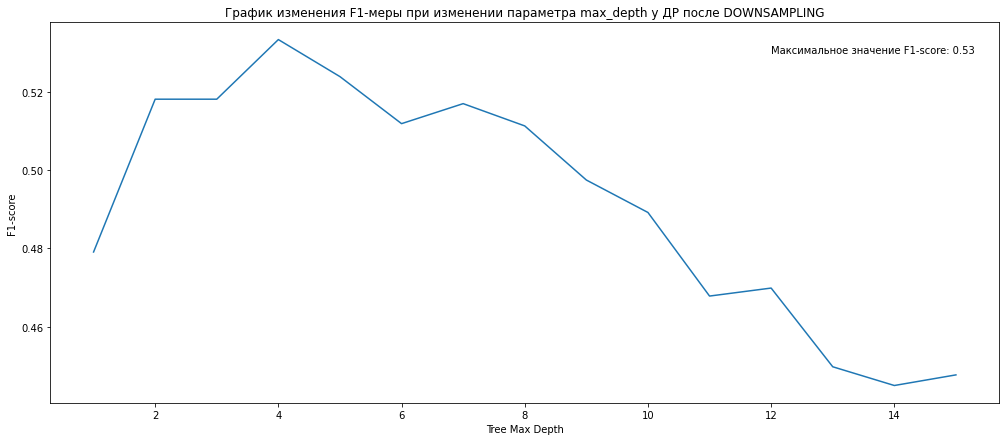

In [90]:
# -------- Дерево решений ----------------------

f_scores_opt_dt = []
depths_opt_dt = []
f_score = 0
opt_model_dt = None

# проверим max_depth от 1 до 15
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted = model.predict(features_valid)

    # запишем лучший F-score и лучшую модель
    if f_score < f1_score(target_valid, predicted):
        f_score = f1_score(target_valid, predicted)
        opt_model_dt = model

    # добавим все F-score и глубины для графика
    f_scores_opt_dt.append(f1_score(target_valid, predicted))
    depths_opt_dt.append(depth)

plt.figure(figsize=(17,7))
sb.lineplot(x=depths_opt_dt, y=f_scores_opt_dt)
plt.xlabel('Tree Max Depth')
plt.ylabel('F1-score')
plt.title('График изменения F1-меры при изменении параметра max_depth у ДР после DOWNSAMPLING')
plt.text(x=12, y=0.53, s='Максимальное значение F1-score: '+str(round(max(f_scores_opt_dt),2)));

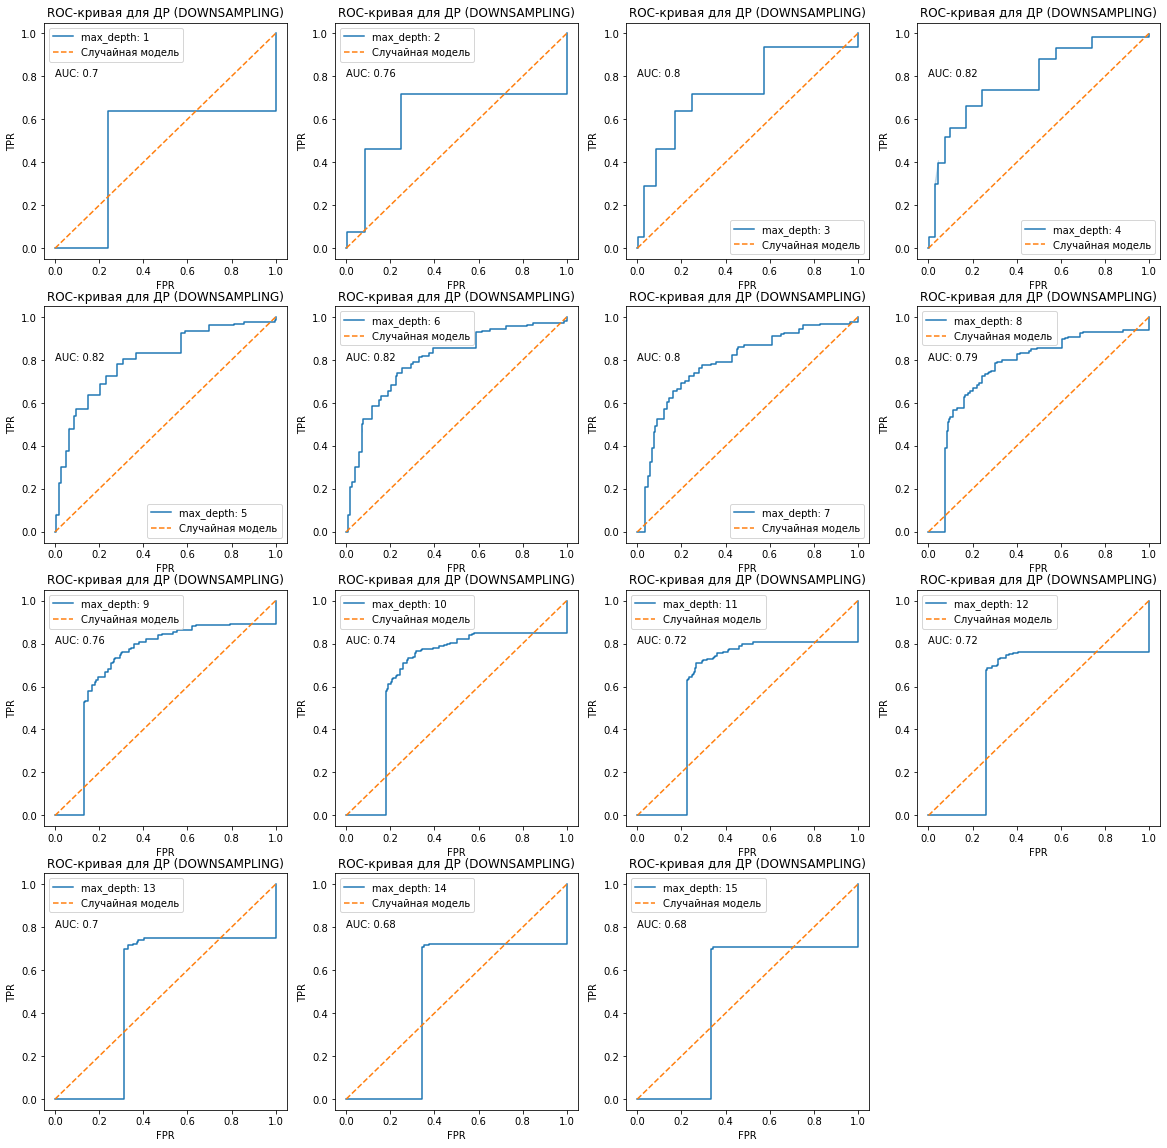

In [91]:
# настроим размер графика
fig = plt.figure(figsize=(20,20))

# проверим max_depth от 1 до 15 
for depth in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted = model.predict(features_valid)
    predicted_proba = model.predict_proba(features_valid)

    # найдем TPR и FPR для модели с max_depth=depth
    fpr, tpr, t = roc_curve(target_valid, predicted_proba[:,1])

    # посчитаем площадь под ROC-кривой
    area_uc = round(roc_auc_score(target_valid, predicted_proba[:,1]), 2)

    # построим график
    axes = fig.add_subplot(4, 4, depth)
    sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='max_depth: '+str(depth))
    sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-кривая для ДР (DOWNSAMPLING)')
    plt.text(y=0.8, x=0.0, s='AUC: '+str(area_uc))

ДР достигает F1-score 0.53 при max_depth=4. ROC-AUC при этом равен 0.82.

DT reaches F1-score 0.53 at max_depth=4. ROC-AUC is equal to 0.82.

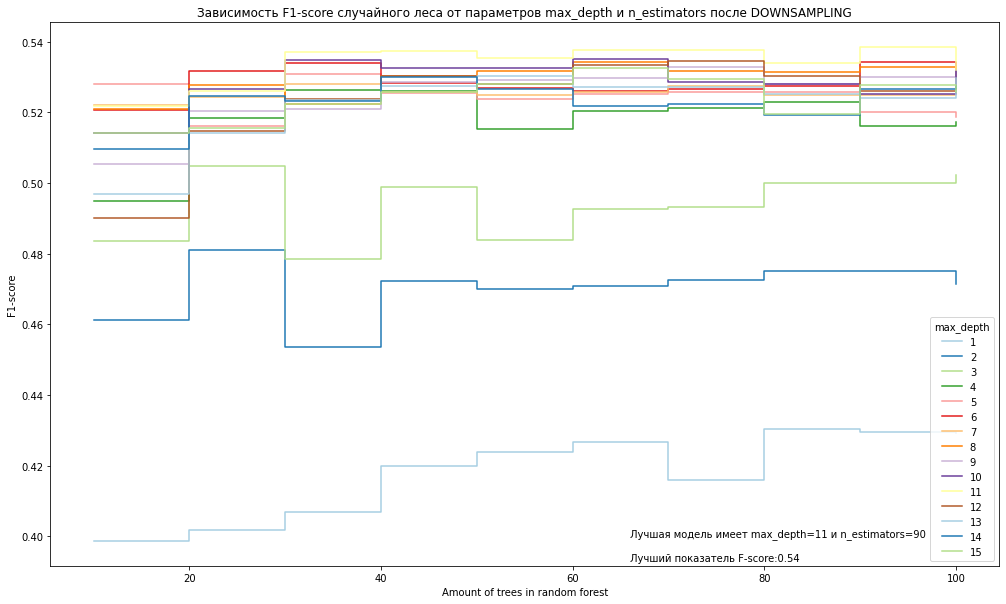

In [92]:
# -------- Случайный лес ----------------------

opt_model_rf = None # для сохранения лучшей модели
rf_opt_accuracy = 0 # для сохранения лучшей точности
rf_opt_n_est = 0 # для сохранения лучшего количества деревьев
rf_opt_depth = 0 # для сохранения лучшей глубины
rf_accuracies = {} # для всех значений точности (ключ - max_depth)
rf_depth = [depth for depth in range(1,16)] # для всех значений глубины
rf_n_est = [n for n in range(10,110,10)] # для всех значений количества деревьев

# проверим значения max_depth от 1 до 15
# проверим значения n_estimatirs от 10 до 100 с шагом 10
for depth in rf_depth:
    temp_accuracies = [] # сохраняем точности моделей с различным кол-вом деревьев
    for n in rf_n_est:
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=n)
        model.fit(features_train_downsampled, target_train_downsampled)
        predictions = model.predict(features_valid)
        accuracy = f1_score(target_valid, predictions)
        temp_accuracies.append(accuracy) # присоединим точность для модели с глубиной depth и кол-вом деревьев
        # от 10 до 100 с шагом 10
        if accuracy > rf_opt_accuracy:
            opt_model_rf = model
            rf_opt_accuracy = accuracy
            rf_opt_n_est = n
            rf_opt_depth = depth
    rf_accuracies[depth] = temp_accuracies # присоединим лист с точностями в словарь, где ключ - глубина depth

# создадим дадафрэйм с результатами и применим к нему функцию melt,
# чтобы построить график
rf_model_df = pd.DataFrame(rf_accuracies, index=rf_n_est).melt(value_vars=rf_depth, value_name='accuracy', var_name='max_depth')

# покажем как менется точность случайного леса
# в зависимости от количества деревьев в нем и их глубины
plt.figure(figsize=(17,10))
sb.lineplot(x=rf_n_est*15, y='accuracy', drawstyle='steps-post', data=rf_model_df, hue='max_depth', palette='Paired')
plt.title('Зависимость F1-score случайного леса от параметров max_depth и n_estimators после DOWNSAMPLING')
plt.xlabel('Amount of trees in random forest')
plt.ylabel('F1-score');
plt.legend(title='max_depth', loc='lower right')
plt.text(x=66, y=0.4, s=f'Лучшая модель имеет max_depth={opt_model_rf.max_depth} и n_estimators={opt_model_rf.n_estimators}')
plt.text(x=66, y=0.393, s='Лучший показатель F-score:'+str(round(rf_opt_accuracy,2)));

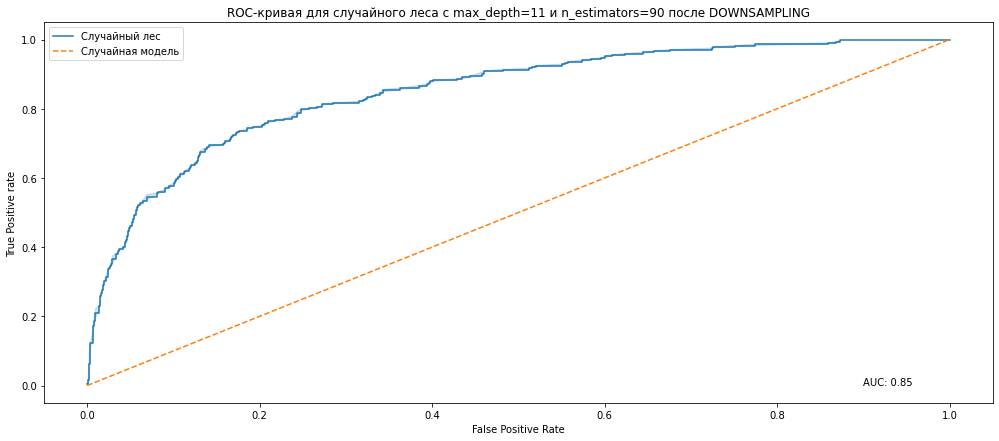

In [93]:
opt_model_rf = RandomForestClassifier(random_state=1, max_depth=11, n_estimators=90)
opt_model_rf.fit(features_train_downsampled, target_train_downsampled)
predicted_proba = opt_model_rf.predict_proba(features_valid)

# рассчитаем true/false positive rate и пороговые значения
fpr, tpr, threshold = roc_curve(target_valid, predicted_proba[:,1])

rf_roc_auc = round(roc_auc_score(target_valid, predicted_proba[:,1]),2)

# ROC-кривая
plt.figure(figsize=(17,7))
sb.lineplot(x=fpr, y=tpr, drawstyle='steps-post', label='Случайный лес')
sb.lineplot(x=ran_fpr, y=ran_tpr, linestyle='--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC-кривая для случайного леса с max_depth=11 и n_estimators=90 после DOWNSAMPLING')
plt.text(x=0.9,y=0.0,s='AUC: '+str(rf_roc_auc));

**DOWNSAMPLING** уменьшил точность СЛ: F1-score = 0.54, а ROC-AUC = 0.85.

**DOWNSAMPLING** decreased RF accuracy: F1-score = 0.54 and ROC-AUC = 0.85.

#### Вывод / Conclusion

In [94]:
pd.DataFrame({
                            'Model_unopt':['LR_unopt', 'LR_unopt', 'DT_unopt', 'DT_unopt', 'RF_unopt', 'RF_unopt'],
                            'Upsampling': [0.42, 0.68, 0.47, 0.67, 0.6, 0.84],
                            'Downsampling': [0.4, 0.68, 0.44, 0.67, 0.52, 0.84],
                            'Class Weighing': [0.37, 0.61, 0.45, 0.67, 0.56, 0.85],
                            'Model_opt':['LR_opt', 'LR_opt', 'DT_opt', 'DT_opt', 'RF_opt', 'RF_opt'],
                            'Upsampling_opt': [0.44, '0.34 (PR-AUC)', 0.54, 0.82, 0.62, 0.85],
                            'Downsampling_opt': [0.45, '0.34 (PR-AUC)', 0.53, 0.82, 0.54, 0.85],
                            'Class Weighing_opt': [None, None, None, None, None, None],
                            }, index=['F-score', 'AUC-ROC']*3)

,Model_unopt,Upsampling,Downsampling,Class Weighing,Model_opt,Upsampling_opt,Downsampling_opt,Class Weighing_opt
F-score,LR_unopt,0.42,0.40,0.37,LR_opt,0.44,0.45,None
AUC-ROC,LR_unopt,0.68,0.68,0.61,LR_opt,0.34 (PR-AUC),0.34 (PR-AUC),None
F-score,DT_unopt,0.47,0.44,0.45,DT_opt,0.54,0.53,None
AUC-ROC,DT_unopt,0.67,0.67,0.67,DT_opt,0.82,0.82,None
F-score,RF_unopt,0.60,0.52,0.56,RF_opt,0.62,0.54,None
AUC-ROC,RF_unopt,0.84,0.84,0.85,RF_opt,0.85,0.85,None


Для борьбы с дисбалансом классов мы использовали три техники: **ВЗВЕШИВАНИЕ КЛАССОВ**, **UPSAMPLING**, и **DOWNSAMPLING**. Сначала мы проверили БАЗОВЫЕ модели на сбалансированных данных, а затем оптимизировали некоторые параметры моделей и проверили их на сбалансированнхы данных еще раз (!!!взвешивание классов не проверялось на оптимизированных моделях!!!). В таблице выше приведены изменения основных метрик для БАЗОВЫХ и ОПТИМИЗИРОВАННЫХ моделей, обученных на сбалансированных данных.

Из данных видно:

- НЕОПТИМИЗИРОВАННАЯ модель СЛ после UPSAMPLING имеет **F1-score = 0.6** и **ROC-AUC = 0.84**.

- ОПТИМИЗИРОВАННАЯ МОДЕЛЬ СЛ после UPSAMPLING имеет **F1-score = 0.62** и **ROC-AUC = 0.85**.

Результаты показывают, что СЛ лучше всех справляется с задачей на сбалансированных данных, даже если не подбирать гиперпараметры для модели. Более того, СЛ достигает целевой F1-меры, даже если будет обучена на несбалансированных данных, но с подбором гиперпараметров (F1score = 0.59).

-----

To combat class imbalance, we used three techniques: **CLASS WEIGHT**, **UPSAMPLING**, and **DOWNSAMPLING**. First, we tested the BASIC models on balanced data, and then we optimized some model parameters and tested them on balanced data again (!!!class weighting was not tested on optimized models!!!). The table above shows the changes in the main metrics for BASIC and OPTIMIZED models trained on balanced data.

From the data you can see:

- UNOPTIMIZED RF model after UPSAMPLING has **F1-score = 0.6** and **ROC-AUC = 0.84**.

- OPTIMIZED RF MODEL after UPSAMPLING has **F1-score = 0.62** and **ROC-AUC = 0.85**.

The results show that RF performs best on balanced data, even without fitting hyperparameters for the model. Moreover, the RF achieves the target F1-measure even if it is trained on unbalanced data, but with hyperparameter fitting (F1score = 0.59).

## Тестирование модели / Model testing

Выберем две самых лучших по результатам тестирования на валидационных данных модели СЛ. Проверим их на тестовой выборке. Если модель без оптимизации гиперпараметров будет выдавать высокие значения на тестовой выборке, то в будущем можно не тратить время на обучение модели.

----

We choose the two best ones based on the results of testing on the validation data of the RF model. Let's check them on a test sample. If the model without hyperparameter optimization produces high values on the test set, then in the future you can not waste time training the model.

In [95]:
# Модель №1

model_rf_1 = RandomForestClassifier(random_state=1)
model_rf_1.fit(features_train_upsampled, target_train_upsampled)
model_1_predictions = model_rf_1.predict(features_test)

# посчитаем F1-score
f1_model_1 = round(f1_score(target_test, model_1_predictions),2)

# посчитаем ROC-AUC
predicted_proba_rf = model_rf_1.predict_proba(features_test)
roc_auc_model_1 = round(roc_auc_score(target_test, predicted_proba_rf[:,1]),2)

print('F1-score для НЕОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING:', f1_model_1)
print('ROC-AUC для НЕОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING:', roc_auc_model_1)


F1-score для НЕОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING: 0.59
ROC-AUC для НЕОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING: 0.85


In [96]:
# Модель №2

model_rf_2 = RandomForestClassifier(random_state=1, max_depth=12, n_estimators=30)
model_rf_2.fit(features_train_upsampled, target_train_upsampled)
model_2_predictions = model_rf_2.predict(features_test)

# посчитаем F1-score
f1_model_2 = round(f1_score(target_test, model_2_predictions),2)

# посчитаем ROC-AUC
predicted_proba_rf = model_rf_2.predict_proba(features_test)
roc_auc_model_2 = round(roc_auc_score(target_test, predicted_proba_rf[:,1]),2)

print('F1-score для ОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING:', f1_model_2)
print('ROC-AUC для ОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING:', roc_auc_model_2)

F1-score для ОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING: 0.61
ROC-AUC для ОПТИМИЗИРОВАННОГО СЛ на ТЕСТОВЫХ данных после UPSAMPLING: 0.85


Модели показывают точность не ниже целевой.

Models show accuracy not lower than the target.

## Общий вывод / Final conclusion

В данном проекте мы строили модель, предсказывающую уход клиентов из банка.

Данные были изучены и подготовлены - удалены лишние колонки, проведено кодирование категориальных данных. Затем данные были разделены на тренировочный, валидационный, и тестовый датасеты.

При изучении данных, в них обнаружился большой дисбаланс между наблюдениями с разными классами. Соотношение составляло 1:4 (положительные:отрицательные).

Для понимания того, как дисбаланс мешает обучению и работе модели сначала мы обучили логистическую регрессию, дерево решений, и случайный лес без оптимизации гиперпараметров на **ИСХОДНЫХ** данных. Логистическая регрессия показала наихудшие результаты (F1 = 0.09, ROC-AUC = 0.68), а случайный лес наилучшие результаты (F1 = 0.56, ROC-AUC = 0.84). Ни одна из моделей при этом не достигла целевого значения точности.

Для сравнения оптимизировали гиперпараметры моделей и снова обучили их на **ИСХОДНЫХ** данных. Как и в случае с неоптимизированной логистической регрессией, оптимизированная работает лучше (F1 = 0.4, PR-AUC = 0.33), но имеет очень низкую точность. Это можно объяснить тем, что логистическая регрессия делает линейное разделение точек, а при ИАД мы выяснили, что зависимости в данных нелинейны. Во-вторых, дисбаланс классов вносит свой вклад.

Следующим шагом была балансировка классов в данных. Для этого применили техники upsampling, downsampling, и взвешивание классов. Как и в случае с исходными данными сначала обучили базовые модели, а затем модели с оптимизированными гиперпараметрами.

Без оптимизации гиперпараметров, **логистическая регрессия**, обученная на **СБАЛАНСИРОВАННЫХ** данных показала результат, намного превышающий (**0.42, 0.4, 0.37** (upsamp, downsamp, weigh) vs 0.09 (исходные данные)) таковой при обучении на исходных данных. Однако ROC-AUC такой модели был близок к 0.5 (**0.68, 0.68, 0.61** (upsamp, downsamp, weigh)), а значит модель предсказывает немного точнее случайной модели.

**Дерево решений**, обученной на **СБАЛАНСИРОВАННЫХ** данных показало результаты не лучше, чем таковые на исходных данных (F1 = 0.47, 0.44, 0.45 (upsamp, downsamp, weigh) vs 0.46(исходные данные)). Можем сделать вывод, что балансировка данных не помогает дереву решений, если не была проведена оптимизация гиперпараметров. Также, ROC-AUC у всех трех моделей (upsamp, downsamp, weigh) составил **0.67**.

**Случайный лес** показал наилучшие результаты на **СБАЛАНСИРОВАННЫХ** данных (F1 = **0.6**, 0.52, 0.56 (upsamp, downsamp, weigh) vs 0.56 (исходные данные)). Таким образом, только upsampling помогает достигнуть целевого значений точности неоптимизированной модели.

Для составления общей картины работы моделей и дальнейшего улучшения их результатов, мы провели обучение на **СБАЛАНСИРОВАННЫХ** (только upsampling и downsampling) и при этом оптимизировали основные гиперапараметры. **Логистическая регрессия** показала результат F1-score = 0.44, 0.45 (upsamp, downsamp), что немного луше у аналогичной модели, обученной на исходных данных. **Дерево решений** показало точность F1 = 0.54, 0.53 (upsamp, downsamp), что немного ниже дерева решений, обученного на исходных данных (0.56). Лучший результат показал **случайный лес**. Его F1-score = 0.62, 0.54 (upsamp, downsamp) при результате F1 = 0.59 у модели на исходных данных.

В результате изучения моделей для тестирования были выбраны следующие:

1) Случайный лес, обученный на данных после UPSAMPLING.

2) Случайный лес (max_depth=12, n_estimators=30), обученный на данных после UPSAMPLING (F1 = 0.59).

На тестовой выборке эти модели показали следующие результаты:

1) F1 = 0.59, ROC-AUC = 0.85

2) F1 = 0.61, ROC-AUC = 0.85

В качестве финальной модели выбрали вторую. Обучается она дольше, но выдает большую точность при предсказании ухода клиента, что очень важно для деятельности банка.

-----

In this project, we built a model that predicts the exit of customers from the bank.

The data was studied and prepared - extra columns were removed, categorical data were coded. Then the data was divided into training, validation, and test datasets.

When examining the data, they found a large imbalance between observations with different classes. The ratio was 1:4 (positive:negative).

To understand how imbalance interferes with training and performance of the model, we first trained logistic regression, decision tree, and random forest without hyperparameter optimization on **INITIAL** data. Logistic regression showed the worst results (F1 = 0.09, ROC-AUC = 0.68), while random forest showed the best results (F1 = 0.56, ROC-AUC = 0.84). None of the models achieved the target accuracy value.

For comparison, the hyperparameters of the models were optimized and trained again on **INITIAL** data. As with the non-optimized logistic regression, the optimized one performs better (F1 = 0.4, PR-AUC = 0.33) but has very low accuracy. This can be explained by the fact that logistic regression makes a linear separation of points, and with IAD we found that the dependencies in the data are non-linear. Second, class imbalance contributes.

The next step was to balance the classes in the data. For this, upsampling, downsampling, and class weighting techniques were used. As in the case with the original data, the base models were first trained, and then the models with optimized hyperparameters.

Without hyperparameter optimization, **logistic regression** trained on **BALANCED** data showed a result much higher than (**0.42, 0.4, 0.37** (upsamp, downsamp, weight) vs 0.09 (baseline data)) training on initial data. However, the ROC-AUC of this model was close to 0.5 (**0.68, 0.68, 0.61** (upsamp, downsamp, weigh)), which means that the model predicts a little more accurately than the random model.

The **Decision Tree** trained on the **BALANCED** data showed no better results than those on the original data (F1 = 0.47, 0.44, 0.45 (upsamp, downsamp, weight) vs 0.46(original data)). We can conclude that data balancing does not help the decision tree if hyperparameter optimization has not been carried out. Also, ROC-AUC for all three models (upsamp, downsamp, weigh) was **0.67**.

**Random forest** performed best on **BALANCED** data (F1 = **0.6**, 0.52, 0.56 (upsamp, downsamp, weight) vs 0.56 (baseline data)). Thus, only upsampling helps to achieve the target accuracy values of the non-optimized model.

In order to get an overall picture of the performance of the models and further improve their results, we trained on **BALANCED** (only upsampling and downsampling) while optimizing the main hyperparameters. **Logistic regression** showed F1-score = 0.44, 0.45 (upsamp, downsamp), which is slightly better than a similar model trained on the original data. **Decision tree** showed an accuracy of F1 = 0.54, 0.53 (upsamp, downsamp), which is slightly lower than the decision tree trained on the original data (0.56). The best result was shown by **random forest**. His F1-score = 0.62, 0.54 (upsamp, downsamp) with the result of F1 = 0.59 for the model on the original data.

As a result of studying the models for testing, the following were chosen:

1) Random forest trained on data after UPSAMPLING.

2) Random forest (max_depth=12, n_estimators=30) trained on data after UPSAMPLING (F1 = 0.59).

On the test sample, these models showed the following results:

1) F1 = 0.59, ROC-AUC = 0.85

2) F1 = 0.61, ROC-AUC = 0.85

The second model was chosen as the final model. It takes longer to learn, but it gives greater accuracy when predicting the client's departure, which is very important for the bank's activities.